<a href="https://colab.research.google.com/github/meland87/firearm_analysis_project/blob/main/meland_M2_891_20242_PEC3_Enunciado_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/content/dam/news/images/noticies/2016/202-nova-marca-uoc.jpg" align="left" width="45%">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.891 · Aprendizaje automático · PEC3</p>
<p style="margin: 0; text-align:right;">2024-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# PEC 3: Métodos supervisados

En esta práctica veremos diferentes métodos supervisados y trataremos de optimizar diferentes métricas. Veremos como los diferentes modelos clasifican las observaciones y con cuales obtenemos mayor rendimiento. Después aplicaremos todo lo que hemos aprendido hasta ahora a un dataset nuevo simulando un caso práctico real.

1. [Exploración de algoritmos supervisados](#ej1) \
    1.1. [Carga de datos](#ej1) \
    1.2. [K vecinos más próximos (KNN)](#ej12) \
    1.3. [Máquinas de soporte vectorial (SVM)](#ej13) \
    1.4. [Árboles de decisión](#ej14)
2. [Comprensión de algoritmos supervisados](#ej2)
3. [Implementación del caso práctico](#ej3)\
    2.1. [Carga de datos](#ej31) \
    2.2. [Análisis Exploratorio de Datos](#ej32) \
    2.3. [Preprocesamiento de Datos](#ej33) \
    2.4. [Modelización](#ej34)


<u>Consideraciones generales</u>:

- La solución planteada no puede utilizar métodos, funciones o parámetros declarados **_deprecated_** en futuras versiones, a excepción de la carga de datos cómo se indica posteriormente.
- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

<div class="alert alert-block alert-info">
    <strong>Nombre y apellidos:</strong>
</div>

In [2]:
import os
import tqdm
import kagglehub
import umap

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

from sklearn import datasets
from sklearn import tree
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score

%matplotlib inline

<a id='ej1'></a>
# 1. Exploración de algoritmos supervisados (3.75 puntos)

## 1.1. Carga de datos

El hundimiento del Titanic es uno de los naufragios más tristemente célebres de la historia. El 15 de abril de 1912, durante su viaje inaugural, el considerado «insumergible» RMS Titanic se hundió tras chocar con un iceberg. Desgraciadamente, no había suficientes botes salvavidas para todos los ocupantes, lo que provocó la muerte de 1.502 de los 2.224 pasajeros y tripulantes. Aunque hubo algo de suerte en la supervivencia, parece que algunos grupos de personas tuvieron más probabilidades de sobrevivir que otros.

En este ejercicio vamos a trabajar con el conjunto de datos [Titanic-Dataset](https://www.kaggle.com/datasets/yasserh/titanic-dataset?select=Titanic-Dataset.csv), el cual contiene la descripción de una parte de los pasajeros y tripulantes del Titanic.

El siguiente código cargará los datos de los pasajeros y realizará una transformación de los mismos. De cada pasajero tenemos información diversa (conjunto X) como la edad o la categoría en la que viajaba, así como la variable objetivo (y), que indica si la persona sobrevivió o no al trágico accidente. Podemos comprobar que la carga ha sido correcta obteniendo las dimensiones de estos dos conjuntos.

In [3]:
root_path = kagglehub.dataset_download("yasserh/titanic-dataset")
dataset_path = os.path.join(root_path, "Titanic-Dataset.csv")
data = pd.read_csv(dataset_path)

data = data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
data = data.dropna()

n_classes = 2
labels = ['No', 'Yes']
categorical_columns = ['Sex', 'Embarked']

cat_df = pd.get_dummies(data[categorical_columns], dtype=int)
data = pd.concat([data, cat_df], axis=1, join="inner")
data = data.drop(columns=categorical_columns)

X = data.drop(columns=['Survived'])
y = data['Survived']

print("Vector X Dimensions: {}".format(X.shape))
print("Vector y Dimensions: {}".format(y.shape))

Vector X Dimensions: (712, 10)
Vector y Dimensions: (712,)


Antes de empezar a trabajar con el problema, es importe analizar si el conjunto de datos está desbalanceado. En la siguiente gráfica podemos comprobar que no hay una desviación elevada, (60/40) aproximadamente.

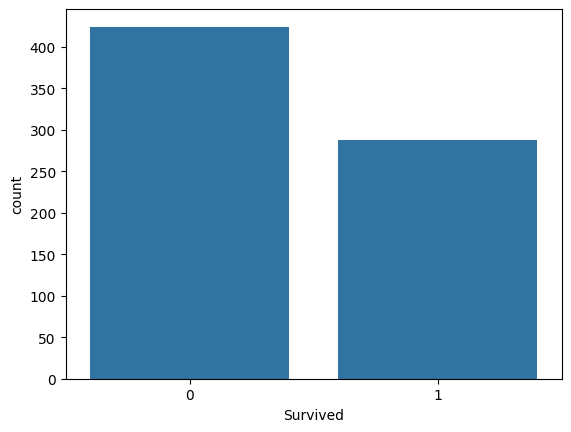

In [4]:
sns.countplot(x='Survived', data=data)
plt.show()

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>

Dividid el _dataset_ en dos subconjuntos, __*train*__ (80% de los datos) y __*test*__ (20% de los datos). Nombrad los conjuntos como: X_train, X_test, y_train, y_test. Utilizad la opción `random_state = 24`.
    
Podéis utilizar la implementación `train_test_split` de `sklearn`.
    
</div>

In [14]:
from sklearn.model_selection import train_test_split

# Aislamos las características y las variables objetivo.
X = data.drop(columns=['Survived'])
y = data['Survived']

# Dividimos los subconjuntos train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24, stratify=y
)

# Comprobamos las dimensiones
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (569, 10)
X_test shape: (143, 10)
y_train shape: (569,)
y_test shape: (143,)
y_test shape: (143,)


Para poder visualizar los resultados de cada algoritmo supervisado, reduciremos el dataset anterior a dos dimensiones.

**NOTA**: Este ejercicio se ha planteado desde un punto de vista didáctico, por lo que utilizaremos en todo el ejercicio el dataset reducido a dos dimensiones con el objetivo de visualizar las fronteras de decisión de los modelos. Aplicar directamente reducción de la dimensionalidad no tiene por qué ser la mejor técnica o aproximación para abordar el problema de aprendizaje supervisado. No obstante, nos servirá para visualizar y profundizar en el entendimiento sobre las fronteras que aprenden los diferentes modelos.

In [16]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# model = umap.UMAP(n_components=2, random_state=42, n_jobs=-1)
# model.fit(X_train)
# X_train_projection = model.transform(X_train)
# X_test_projection = model.transform(X_test)

# fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# for i in range(n_classes):
#    ax.scatter(X_test_projection[y_test == i,0], X_test_projection[y_test == i,1], s=40, marker='o', label=labels[i])
# plt.legend()
# plt.tight_layout()

# plt.show()

## Modifico este código para poder trabajar con la implementación alternativa para
## fijar los límites de decisión.

# Dimensionality reduction to 2 principal components
# Reducimos la dimensión a 2 componentes solamente.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler # import the scaler

# Escalamos los datos
scaler = StandardScaler() # Creamos un scaler object
X_train_scaled = scaler.fit_transform(X_train)
# Adecuamos y transformamos los datos de entrenamiento
X_test_scaled = scaler.transform(X_test)
# Transformamos los datos de test

# Aplicamos PCA los datos escalados de entrenamiento y test.
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Dimensions after PCA - Training set:", X_train_pca.shape)
print("Dimensions after PCA - Test set:", X_test_pca.shape)


Dimensions after PCA - Training set: (569, 2)
Dimensions after PCA - Test set: (143, 2)


A lo largo del ejercicio aprenderemos a ver gráficamente las fronteras de decisión que nos devuelven los diferentes modelos. Para ello utilizaremos la función definida a continuación, que sigue los siguientes pasos:

1. Crear una meshgrid con los valores mínimo y máximo de 'x' e 'y'.
2. Predecir el clasificador con los valores de la meshgrid.
3. Hacer un reshape de los datos para tener el formato correspondiente.

Una vez hecho esto, ya podemos hacer el gráfico de las fronteras de decisión y añadir los puntos reales. Así veremos las áreas que el modelo considera que son de una clase y las que considera que son de otra. Al poner encima los puntos veremos si los clasifica correctamente en el área que les corresponde.

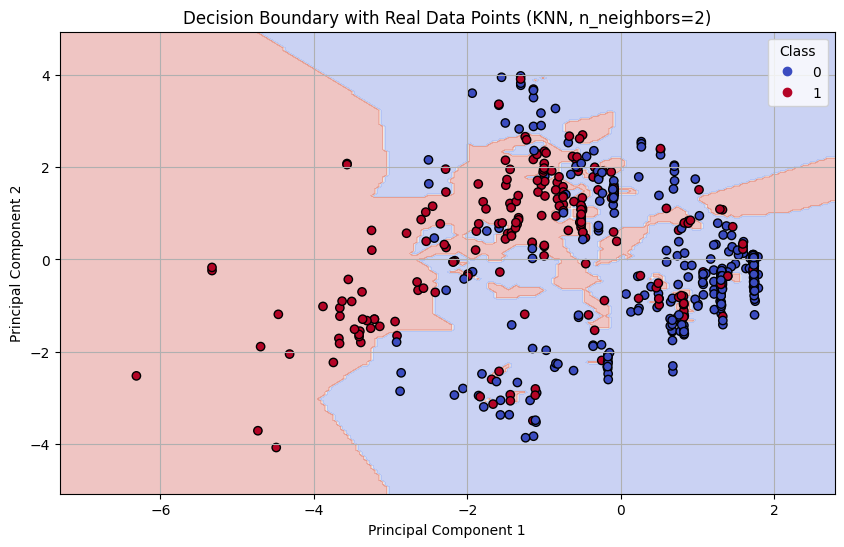

In [17]:
# Define the function that will visualize the decision boundary
#def plot_decision_boundaries(model, X_test_projection, y_test):

    # Create the meshgrid with the minimum and maximum values of the x and y axes
 #   x_min, x_max = X_test_projection[:, 0].min() - 1, X_test_projection[:, 0].max() + 1
 #   y_min, y_max = X_test_projection[:, 1].min() - 1, X_test_projection[:, 1].max() + 1

 #   xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
 #                        np.arange(y_min, y_max, 0.05))

    # Prediction by using all values of the meshgrid
  #  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Define the colors (one for each class)
  #  cmap_light = ListedColormap(['gainsboro','lightgreen','peachpuff','lightcyan', 'pink'])
  #  cmap_bold = ['g','sandybrown','c','palevioletred']

    # Draw the borders
  #  Z = Z.reshape(xx.shape)
  #  plt.figure(figsize=(20,10))
  #  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Draw the points
  #  for i in range(n_classes):
  #      plt.scatter(X_test_projection[y_test == i,0], X_test_projection[y_test == i,1],
  #                  s=40, marker='o', label=labels[i], c=cmap_bold[i])
  #  plt.legend()
  #  plt.xlim(xx.min(), xx.max())
  #  plt.ylim(yy.min(), yy.max())
  #  plt.show()

### He tratado de realizar algunos ejemplos con esta función. Me ha costado entenderla.
### Por ello, trabajaré con una versión de código alternativa.

# Visualización de los límtes de decisión con los datos reales
import numpy as np
import matplotlib.pyplot as plt

# Adecuamos el modelo en PCA-reduced training data
knn_pca = KNeighborsClassifier(n_neighbors=2)
knn_pca.fit(X_train_pca, y_train)

# Creamos un meshgrid sobre el espacio PCA
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                     np.arange(y_min, y_max, 0.05))

# Predecimos sobre el grid
Z = knn_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Dibujamos la frontera de decisión
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

# Dibujamos los puntos de los datos de entrenamiento
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
                      c=y_train, edgecolor='k', cmap=plt.cm.coolwarm)

# Etiquetamos y creamos una leyenda
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Decision Boundary with Real Data Points (KNN, n_neighbors=2)")
plt.legend(*scatter.legend_elements(), title="Class")
plt.grid(True)
plt.show()


<a id='ej12'></a>
## 1.2. KNN (1.25 puntos)

En este punto, vas a entender el funcionamiento del algoritmo KNN (K-Nearest-Neighbor), que se basa en la proximidad de los puntos de datos en un espacio de características. Analizarás sus ventajas y desventajas, y comprenderás cómo los parámetros que lo componen influyen en su comportamiento.

KNN es un algoritmo de tipo supervisado basado en instancia. Esto significa:

- Supervisado: Tu conjunto de datos de entrenamiento está etiquetado con la clase o resultado esperado.
- Basado en instancia (_Lazy Learning_): El algoritmo no aprende explícitamente un modelo, como en la Regresión Logística o los árboles de decisión. En cambio, memoriza las instancias de entrenamiento y las utiliza como "conocimiento" en la fase de predicción.

Para entender cómo funciona KNN, sigue estos pasos:

1. Calcula la distancia entre el ítem a clasificar y los demás ítems del dataset de entrenamiento.
2. Selecciona los "k" elementos más cercanos, es decir, aquellos con la menor distancia, según el tipo de distancia que utilices (euclídea, coseno, manhattan, etc).
3. Realiza una "votación de mayoría" entre los k puntos seleccionados: la clase que predomine en estos puntos decidirá la clasificación final del ítem analizado.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Realiza los siguientes pasos con el dataset de entrenamiento (_train_):

1. Entrena un clasificador KNN con el hiperparámetro `n_neighbors=2` usando el clasificador `KNeighborsClassifier` de `sklearn`.
2. Calcula el _accuracy_ (precisión) del modelo tanto en los datos de _train_ como de _test_.
3. Calcula la matriz de confusión utilizando los datos de _test_.
4. Representa gráficamente la frontera de decisión con los datos de _test_.

Si al entrenar el clasificador aparece un aviso (warning) y deseas ignorarlo, ejecuta el siguiente código antes del entrenamiento:

`import warnings`
`warnings.filterwarnings('ignore', message='^.*will change.*$', category=FutureWarning)`"

Esto te permitirá evaluar la efectividad del modelo KNN con `n_neighbors=2` en tu conjunto de datos, y entender cómo se comporta en términos de clasificación y separación de clases.    
    
    
    
</div>

In [19]:
import warnings
warnings.filterwarnings('ignore', message='^.*will change.*$', category=FutureWarning)

En el modelo que has entrenado, has fijado el parámetro `n_neighbors` de forma arbitraria. Sin embargo, es posible que con otro valor obtengas una mejor predicción. Para encontrar el valor óptimo de los parámetros de un modelo (_hyperparameter tunning_), a menudo se utiliza una búsqueda de rejilla (_grid search_). Esto implica entrenar un modelo para cada combinación posible de hiperparámetros y evaluarlo mediante validación cruzada (_cross validation_) con 5 particiones estratificadas. Luego, seleccionarás la combinación de hiperparámetros que haya obtenido los mejores resultados.

En este caso, te centrarás en optimizar un solo hiperparámetro:

- 𝑘: el número de vecinos que se consideran para clasificar un nuevo ejemplo. Debes probar con todos los valores entre 1 y 20.

Realiza este proceso para identificar el número óptimo de vecinos, lo que te permitirá mejorar la precisión de tus predicciones con el modelo KNN.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>

Para calcular el valor óptimo del hiperparámetro _k_ (`n_neighbors`), debes realizar una búsqueda de rejilla con validación cruzada. Este proceso te ayudará a encontrar el valor óptimo de _k_. Para cada valor, calcula su promedio y la desviación estándar. Luego, implementa un _lineplot_ para visualizar la precisión según los diferentes valores del hiperparámetro.

Utiliza el módulo `GridSearchCV` de `sklearn` para calcular el mejor hiperparámetro. Para la visualización del _lineplot_, emplea la librería `Seaborn`.

Estos pasos te permitirán identificar de manera efectiva y visual el valor de _k_ que maximiza la precisión de tu modelo KNN."
</div>

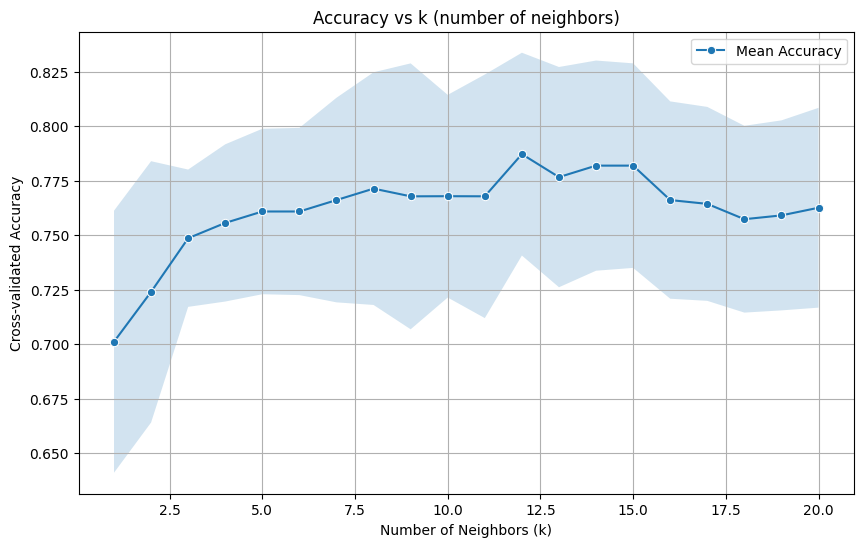

Best number of neighbors (k): 12
Best cross-validated accuracy: 0.7871914299021892


In [20]:
# Importamos los módulos necesarios para realizar la búsqueda de la rejilla con
# validación cruzada para encontrar el número óptimo de vecinos (k).
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Definimos la rejilla
param_grid = {'n_neighbors': list(range(1, 21))}

# Iniciamos la búsqueda en la rejilla.
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=5,  # Validación cruzada de 5 pliegues.
    scoring='accuracy',
    return_train_score=True
)

# Adecuamos la búsqueda en la rejilla sobre zona PCA.
grid_search.fit(X_train_pca, y_train)

# Convertimos los resultado en Dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Dibujamos la media precisa para cada k con su respectiva desviación típica.
plt.figure(figsize=(10, 6))
sns.lineplot(
    x=results['param_n_neighbors'],
    y=results['mean_test_score'],
    marker='o',
    label='Mean Accuracy'
)
plt.fill_between(
    results['param_n_neighbors'],
    results['mean_test_score'] - results['std_test_score'],
    results['mean_test_score'] + results['std_test_score'],
    alpha=0.2
)
plt.title("Accuracy vs k (number of neighbors)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-validated Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# Dibujamos el mejor valor de k
print("Best number of neighbors (k):", grid_search.best_params_['n_neighbors'])
print("Best cross-validated accuracy:", grid_search.best_score_)


<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Sigue estos pasos con el dataset de entrenamiento (_train_):

1. Entrena un clasificador KNN utilizando el mejor hiperparámetro que hayas encontrado.
2. Calcula el _accuracy_ (precisión) del modelo tanto en los datos de _train_ como de _test_.
3. Calcula la matriz de confusión utilizando los datos de _test_.
4. Representa gráficamente la frontera de decisión con los datos de _test_.

Este proceso te permitirá ver cómo el hiperparámetro óptimo que has identificado mejora la efectividad de tu modelo KNN en la clasificación de los datos.
</div>

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Clasificador KNN con el mejor hiperparámetro
# Origen: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
best_k = grid_search.best_params_['n_neighbors']
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

# Predictores
y_train_pred = knn.predict(X_train_scaled)
y_test_pred = knn.predict(X_test_scaled)

# "Precisores"
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Train Accuracy: 0.8189806678383128
Test Accuracy: 0.8181818181818182


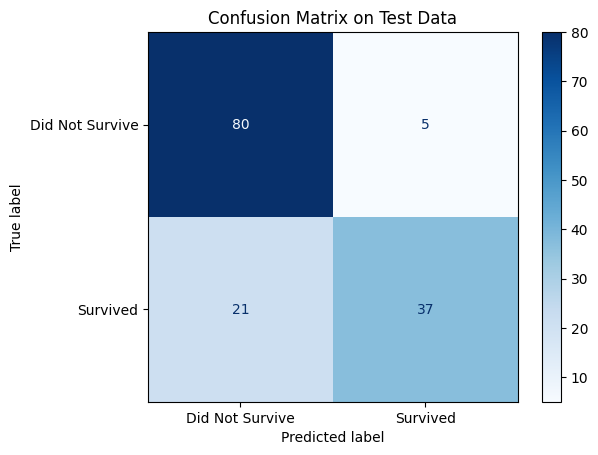

In [22]:
# Matriz de confusión sobre los datos de test.
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did Not Survive', 'Survived'])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Test Data")
plt.show()


<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

1. Comenta los resultados obtenidos en la búsqueda del mejor hiperparámetro. Reflexiona sobre cómo varió el rendimiento del modelo con los diferentes valores de `n_neighbors`.
2. Analiza cómo se visualiza gráficamente el cambio del valor de `n_neighbors`. ¿Observas alguna tendencia o patrón claro? ¿Es coherente esta diferencia entre los dos gráficos al cambiar el parámetro?
3. Examina las fronteras de decisión que has generado. ¿La forma de estas fronteras tiene sentido dado el algoritmo KNN utilizado? Piensa en cómo la elección del número de vecinos influye en la forma de la frontera.
4. Evalúa las predicciones realizadas sobre el conjunto de test. Observa su precisión y cómo se distribuyen en relación con las fronteras de decisión. ¿Son estas predicciones consistentes con lo que observas en las fronteras de decisión?

Este análisis te ayudará a comprender la eficacia del modelo KNN con diferentes configuraciones de `n_neighbors` y su impacto en la clasificación de los datos."
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>


</div>

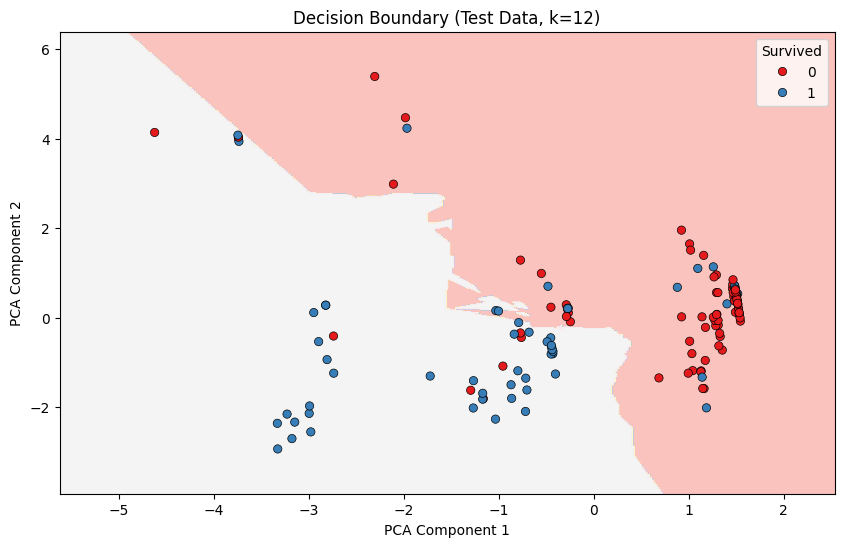

In [24]:
# Disminución de la dimensión de los datos de test por PCA
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_scaled)

# Adecuamos el clasificador KNN sobre los datos de prueba reducidos por PCA con
# el fin de visualizar estos.
knn_vis = KNeighborsClassifier(n_neighbors=best_k)
knn_vis.fit(X_test_pca, y_test)

# Dibujo de la frontera de decisión.
import numpy as np

h = .02  # Fijamos el tamaño de paso en la malla.
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = knn_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1, alpha=0.8)
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=y_test, palette="Set1", edgecolor='k')
plt.title(f"Decision Boundary (Test Data, k={best_k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Survived")
plt.show()


<a id='ej13'></a>
## 1.3. SVM (1.25 puntos)

En esta sección, vas a explorar las Máquinas de Vectores de Soporte (SVM), que se basan en el concepto del _Maximal Margin Classifier_ y el hiperplano.

Un hiperplano en un espacio p-dimensional se define como un subespacio plano y afín de dimensiones p-1. En dos dimensiones, es una recta; en tres, un plano convencional. Para dimensiones mayores a tres, aunque no es intuitivo visualizarlo, el concepto se mantiene.

Cuando los casos son perfectamente separables de manera lineal, surgen infinitos posibles hiperplanos. Para seleccionar el clasificador óptimo, utiliza el concepto de _maximal margin hyperplane_, el hiperplano que se encuentra más alejado de todas las observaciones de entrenamiento. Este se define calculando la distancia perpendicular mínima (margen) de las observaciones a un hiperplano. El hiperplano óptimo es aquel que maximiza este margen.

En el proceso de optimización, debes tener en cuenta que solo las observaciones al margen o que lo violan (vectores soporte) influyen en el hiperplano. Estos vectores soporte son los que definen el clasificador.

#### Los _kernels_ en SVM

En situaciones donde no puedes encontrar un hiperplano que separe dos clases, es decir, cuando las clases no son linealmente separables, puedes utilizar el truco del núcleo (_kernel trick_). Este método te permite trabajar en una dimensión nueva donde es posible encontrar un hiperplano para separar las clases.

Al igual que con el KNN, las SVM también dependen de varios hiperparámetros. En este caso, te enfocarás en optimizar dos hiperparámetros:

1. **C**: la regularización, que es el valor de penalización de los errores en la clasificación. Este valor indica el compromiso entre obtener el hiperplano con el margen más grande posible y clasificar correctamente el máximo número de ejemplos. Debes probar los siguientes valores: 0.01, 0.1, 1, 10, 50, 100 y 200.
   
2. **Gamma**: un coeficiente que multiplica la distancia entre dos puntos en el kernel radial. En términos simples, cuanto más pequeño sea gamma, más influencia tendrán dos puntos cercanos. Debes probar los valores: 0.001, 0.01, 0.1, 1 y 10.

Para validar el rendimiento del algoritmo con cada combinación de hiperparámetros, utiliza la validación cruzada (_cross-validation_) con 5 particiones estratificadas."

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>


1. Calcula el valor óptimo de los hiperparámetros _C_ y _gamma_ utilizando una búsqueda de rejilla con validación cruzada. Este proceso te ayudará a encontrar los valores óptimos.
2. Para cada combinación de valores, calcula su promedio y la desviación estándar.
3. Haz un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.

Utiliza el módulo `GridSearchCV` de `sklearn` para calcular los mejores hiperparámetros con el clasificador SVC (de `SVM` de `sklearn`). Para la visualización del _heatmap_, emplea la librería `Seaborn`.

Estos pasos te permitirán identificar de manera efectiva y visual los valores de _C_ y _gamma_ que maximizan la precisión de tu modelo SVM.
</div>

In [28]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Defnimos el parámetro de la rejilla
param_grid_svm = {
    'C': [0.01, 0.1, 1, 10, 50, 100, 200],
    'gamma': [0.001, 0.01, 0.1, 1, 10]
}

# Modelamos SVM
svm = SVC(kernel='rbf')

# Búsqueda en la rejilla con validación cruzada de 5 pliegues.
grid_search_svm = GridSearchCV(
    svm,
    param_grid=param_grid_svm,
    cv=5,
    scoring='accuracy',
    return_train_score=True
)

# Adecuamos sobre el los datos de entrenamiento reducidos por PCA.
grid_search_svm.fit(X_train_pca, y_train)

# Best parameters and accuracy
# Mostramos los mejores parámetros y la mejor precisión.
print("Best parameters:", grid_search_svm.best_params_)
print("Best CV accuracy:", grid_search_svm.best_score_)


Best parameters: {'C': 10, 'gamma': 0.1}
Best CV accuracy: 0.7906691507529887


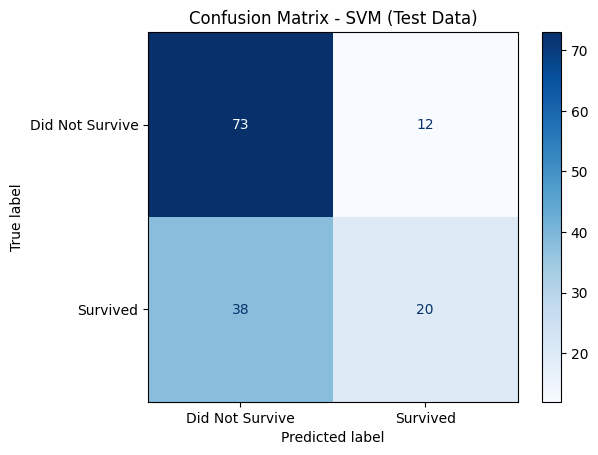

In [29]:
# Matriz de precisión par generar predicciones sobre los datos de test.
y_test_pred_svm = grid_search_svm.predict(X_test_pca)

cm_svm = confusion_matrix(y_test, y_test_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=["Did Not Survive", "Survived"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - SVM (Test Data)")
plt.show()

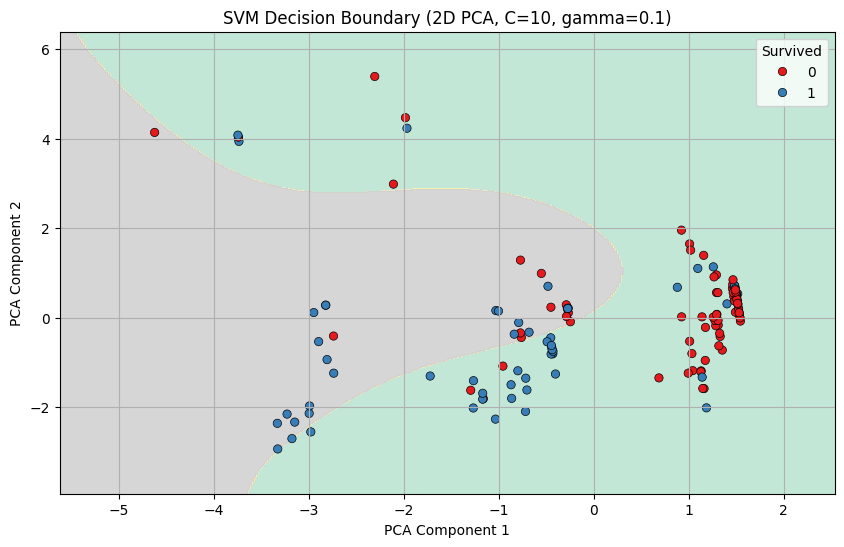

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Asumimos que se usa el mejor modelo SVM de GridSearchCV
svm_best = grid_search_svm.best_estimator_  # AAsignamos el mejor estimador

# Obtención de los mejores hiperparámetros de grid_search_svm
best_C = grid_search_svm.best_params_['C']
best_gamma = grid_search_svm.best_params_['gamma']

# Meshgrid
h = 0.02
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predictores sobre meshgrid
Z = svm_best.predict(np.c_[xx.ravel(), yy.ravel()])  # svm_best se define
# como el mejor
Z = Z.reshape(xx.shape)

# Predicción sobre meshgrid
Z = svm_best.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Dibujamos
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel2, alpha=0.8)
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=y_test, palette='Set1', edgecolor='k')
plt.title(f"SVM Decision Boundary (2D PCA, C={best_C}, gamma={best_gamma})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Survived")
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Realiza los siguientes pasos con el dataset de entrenamiento (_train_):

1. Entrena un modelo SVM utilizando la mejor combinación de parámetros que hayas encontrado.
2. Calcula el _accuracy_ (precisión) del modelo tanto en los datos de _train_ como de _test_.
3. Calcula la matriz de confusión utilizando los datos de _test_.
4. Representa gráficamente la frontera de decisión con los datos de _test_.

Este proceso te permitirá ver cómo la mejor combinación de parámetros mejora la efectividad de tu modelo SVM en la clasificación de los datos.
</div>

In [32]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Recuperación de los mejores parámetros.
best_C = grid_search_svm.best_params_['C']
best_gamma = grid_search_svm.best_params_['gamma']

# Entrenamos el modelo SVM final con los mejores parámetros
svm_best = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
svm_best.fit(X_train_pca, y_train)

# Predicción
y_train_pred_svm = svm_best.predict(X_train_pca)
y_test_pred_svm = svm_best.predict(X_test_pca)

# Precisión
acc_train_svm = accuracy_score(y_train, y_train_pred_svm)
acc_test_svm = accuracy_score(y_test, y_test_pred_svm)

print("Train Accuracy (SVM):", acc_train_svm)
print("Test Accuracy (SVM):", acc_test_svm)

Train Accuracy (SVM): 0.7908611599297012
Test Accuracy (SVM): 0.6503496503496503


<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

1. Comenta los resultados obtenidos en la búsqueda de los mejores hiperparámetros. Reflexiona sobre cómo varió el rendimiento del modelo SVM con los diferentes valores de _C_ y _gamma_. Considera si los valores óptimos encontrados tienen sentido en el contexto de tu conjunto de datos.
2. Examina las fronteras de decisión que has generado con el modelo SVM. ¿La forma de estas fronteras es coherente con lo que esperarías del algoritmo utilizado? Piensa en cómo la combinación de hiperparámetros seleccionados podría influir en la forma de las fronteras.
3. Evalúa las predicciones realizadas sobre el conjunto de test. Observa su precisión y cómo se distribuyen en relación con las fronteras de decisión. ¿Son estas predicciones consistentes con lo que observas en las fronteras de decisión?

Este análisis te ayudará a comprender la eficacia del modelo SVM con los hiperparámetros seleccionados y su impacto en la clasificación de los datos."
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>


</div>

<a id='ej14'></a>
## 1.4. Árboles de decisión (1.25 puntos)

En esta sección, vas a explorar los árboles de decisión, modelos predictivos que se basan en reglas binarias (si/no) para clasificar las observaciones según sus atributos y predecir el valor de la variable respuesta. Estos árboles pueden ser clasificadores, como en tu ejemplo, o regresores para predecir variables continuas.

#### Construcción de un Árbol

Para construir un árbol, sigue el algoritmo de *recursive binary splitting*:

1. Comienza en la parte superior del árbol, donde todas las observaciones pertenecen a la misma región.
2. Identifica todos los posibles puntos de corte para cada uno de los predictores. Estos puntos de corte son los diferentes niveles de los predictores.
3. Evalúa las posibles divisiones para cada predictor utilizando una medida específica. En los clasificadores, estas medidas pueden ser el *classification error rate*, el índice Gini, la entropía o el chi-square.

Comprender estos pasos te ayudará a entender cómo los árboles de decisión crean divisiones binarias para clasificar los datos y cómo estos pueden aplicarse tanto para clasificación como para regresión.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Sigue estos pasos:

1. Con el dataset de entrenamiento, entrena un árbol de decisión utilizando el clasificador `DecisionTreeClassifier` de la biblioteca `tree` de `sklearn`.
2. Calcula el _accuracy_ (precisión) del modelo tanto en los datos de _train_ como de _test_.
3. Calcula la matriz de confusión utilizando los datos de _test_.
4. Representa gráficamente la frontera de decisión con los datos de _test_.
5. Representa el árbol de decisión. Puedes utilizar el comando `plot.tree` de la biblioteca `tree` de `sklearn`.

Estos pasos te permitirán evaluar cómo el árbol de decisión se comporta en tu conjunto de datos, tanto en términos de clasificación como en su representación visual."
</div>

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Entrenamiento del modelo con los datos de entrenamiento reducidos por PCA
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_pca, y_train)

# Predicciones
y_train_pred_dt = dt.predict(X_train_pca)
y_test_pred_dt = dt.predict(X_test_pca)

# Precisiones
train_acc_dt = accuracy_score(y_train, y_train_pred_dt)
test_acc_dt = accuracy_score(y_test, y_test_pred_dt)

print("Decision Tree Train Accuracy:", train_acc_dt)
print("Decision Tree Test Accuracy:", test_acc_dt)


Decision Tree Train Accuracy: 0.9894551845342706
Decision Tree Test Accuracy: 0.5244755244755245


<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

1. Evalúa y comenta los resultados obtenidos con el árbol de decisión. Considera tanto el _accuracy_ del modelo en los conjuntos de _train_ y _test_ como los resultados de la matriz de confusión.
2. Reflexiona sobre cómo la frontera de decisión visualizada en el conjunto de _test_ se alinea con los resultados obtenidos. ¿Es coherente con lo que esperarías de un árbol de decisión?
3. Observa la representación gráfica del árbol. Analiza cómo las diferentes ramificaciones y decisiones tomadas en el árbol explican el comportamiento del modelo y su impacto en la clasificación de los datos.

Este análisis te ayudará a comprender en profundidad el funcionamiento y la eficacia del árbol de decisión en tu conjunto de datos específico.

</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>


</div>

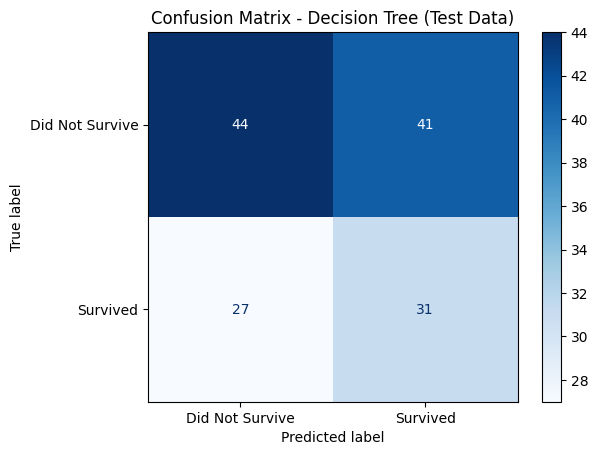

In [35]:
# Matriz de confusión
cm_dt = confusion_matrix(y_test, y_test_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["Did Not Survive", "Survived"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Decision Tree (Test Data)")
plt.show()

#### Evitando el *overfitting*

El proceso de construcción de árboles descrito tiende a reducir rápidamente el error de entrenamiento, por lo que generalmente el modelo se ajusta muy bien a las observaciones utilizadas como entrenamiento (conjunto de *train*). Como consecuencia, los árboles de decisión tienden al *overfitting*.
   
Para evitar el *overfitting* en los árboles de decisión, es crucial que modifiques ciertos hiperparámetros del modelo de la siguiente manera:

1. Utiliza el hiperparámetro `max_depth`, que define la profundidad máxima del árbol. Deberás explorar los valores entre 4 y 10 para encontrar el equilibrio adecuado entre la complejidad del modelo y su capacidad para generalizar.
2. Establece el hiperparámetro `min_samples_split`, que es el número mínimo de observaciones que debe tener una hoja del árbol antes de considerar una división. Experimenta con valores como 2, 10, 20, 50 y 100 para asegurarte de que el árbol no se vuelva demasiado específico para las observaciones de entrenamiento.

Ajustando estos hiperparámetros, podrás controlar la tendencia del árbol de decisión a sobreajustarse al conjunto de entrenamiento, mejorando así su capacidad para realizar predicciones efectivas en nuevos datos."

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>

1. Calcula el valor óptimo de los hiperparámetros `max_depth` y `min_samples_split` utilizando una búsqueda de rejilla con validación cruzada. Este proceso te ayudará a encontrar los valores óptimos que evitarán el sobreajuste.
2. Para cada combinación de valores, calcula su promedio y la desviación estándar.
3. Haz un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.

Utiliza el módulo `GridSearchCV` de `sklearn` para calcular los mejores hiperparámetros con el clasificador `DecisionTreeClassifier` de `tree` de `sklearn`. Para la visualización del _heatmap_, emplea la librería `Seaborn`.

Estos pasos te permitirán identificar de manera efectiva y visual los valores de `max_depth` y `min_samples_split` que maximizan la precisión de tu árbol de decisión, minimizando el riesgo de sobreajuste.
</div>

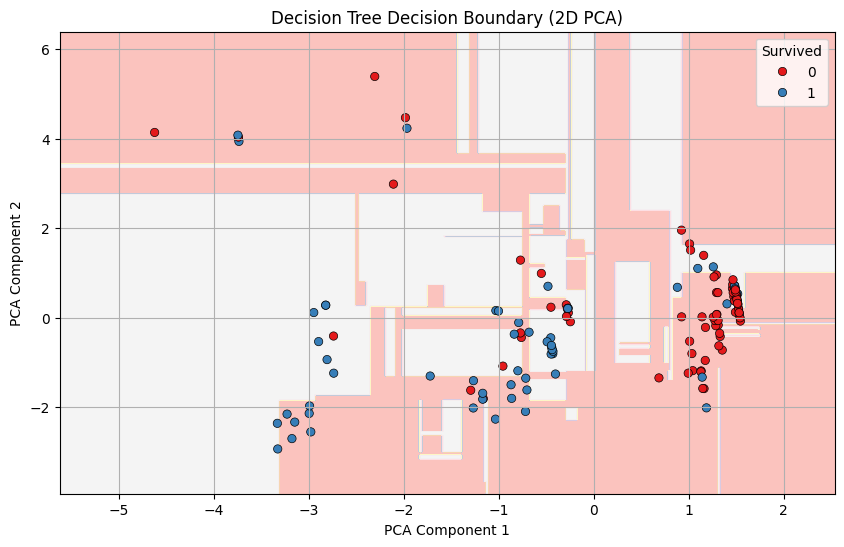

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Creación meshgrid
h = 0.02
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predicción para los puntos de la malla.
Z = dt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Dibujo de la frontera de decisión.
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1, alpha=0.8)
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=y_test, palette='Set1', edgecolor='k')
plt.title("Decision Tree Decision Boundary (2D PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Survived")
plt.grid(True)
plt.show()


<div class="alert alert-block alert-info">
<strong>Implementación:</strong>


1. Entrena un árbol de decisión con el dataset de entrenamiento (_train_) utilizando la mejor combinación de parámetros que hayas encontrado.
2. Calcula el _accuracy_ (precisión) del modelo tanto en los datos de _train_ como de _test_.
3. Calcula la matriz de confusión utilizando los datos de _test_.
4. Representa gráficamente la frontera de decisión con los datos de _test_.
5. Representa el árbol de decisión.

Estos pasos te permitirán evaluar cómo el árbol de decisión, ajustado con los hiperparámetros óptimos, se comporta en tu conjunto de datos, tanto en términos de clasificación como en su representación visual."
    
</div>

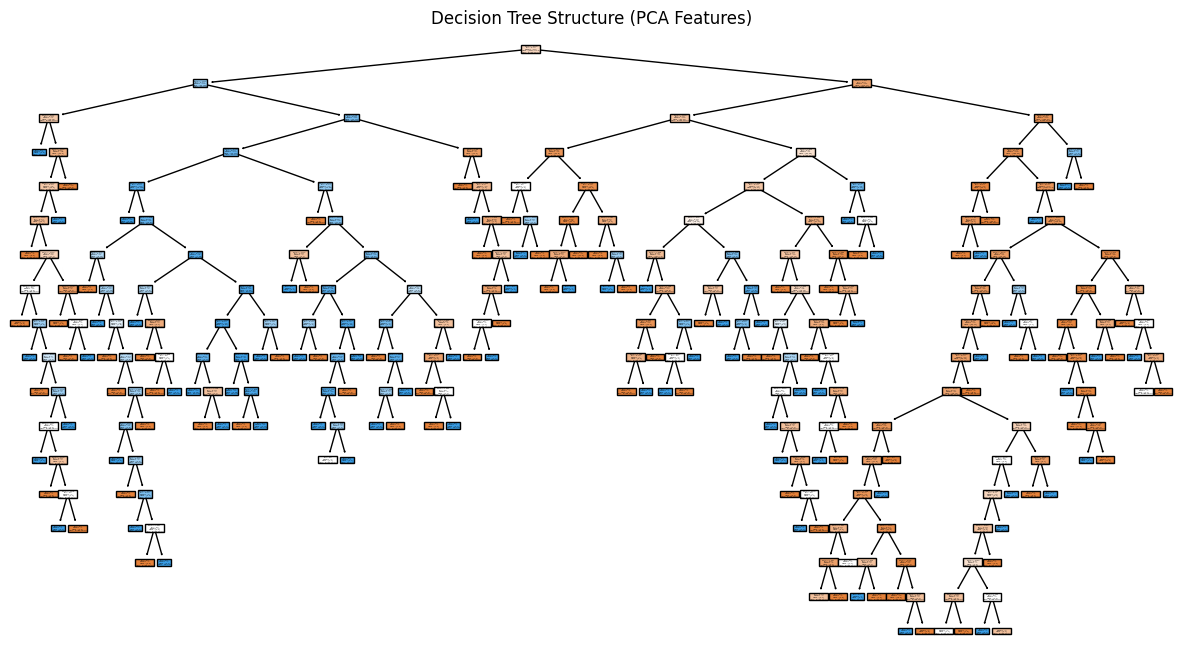

In [37]:
from sklearn import tree
plt.figure(figsize=(15, 8))
tree.plot_tree(dt, filled=True, feature_names=["PCA1", "PCA2"], class_names=["Did Not Survive", "Survived"])
plt.title("Decision Tree Structure (PCA Features)")
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

1. Evalúa y comenta los resultados obtenidos en la búsqueda de los mejores hiperparámetros. Considera cómo la combinación óptima de `max_depth` y `min_samples_split` ha impactado el rendimiento del árbol de decisión.
2. Examina las fronteras de decisión generadas con el conjunto de _test_. Reflexiona sobre si la forma de estas fronteras es coherente con lo que esperarías de un árbol de decisión configurado con estos hiperparámetros.
3. Analiza las predicciones realizadas sobre el conjunto de test. Observa su precisión y cómo se distribuyen en relación con las fronteras de decisión. ¿Son consistentes estas predicciones con la estructura del árbol de decisión y las fronteras observadas?

Este análisis te ayudará a comprender la eficacia del árbol de decisión con los hiperparámetros seleccionados y su impacto en la clasificación de los datos.
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>


</div>

<a id='ej2'></a>
# 2. Comprensión de algoritmos supervisados (3.25 puntos)

En este ejercicio vamos a profundizar en la compresión de los algoritmos supervisados que hemos estudiado, en concreto, Árboles de decisión y Knn. Para ello vamos a trabajar con un problema de regresión muy sencillo (un único atributo descriptivo) que se resolvería de forma directa con una regresión lineal.

**IMPORTANTE:** En este ejercicio no se pueden utilizar otros modelos, ni técnicas como _ensemble learning_ ni usar otras librerías diferentes a la indicadas e importadas al inicio de la PEC. En este ejercicio tenemos que seguir las indicaciones que se proporcionarán en cada sección, dónde nos centraremos en transformar el problema (datos) para conseguir resolver nuestro problema.

En este ejercicio nos vamos a apoyar en la función _plot_regression_, la cual nos permitirá representar de forma sencilla las soluciones obtenidas.

**NOTA:** En este ejercicio vamos a realizar muchos análisis visuales con el objetivo profundizar en los conocimientos teóricos vistos en el módulo. Este ejercicio se va a realizar con un fin didáctico, en la realidad siempre hay que apoyarse en varias métricas objetivas para el problema que estemos resolviendo, además, por supuesto, de visualizar si es posible el problema que estemos resolviendo.

In [38]:
def plot_regression(x_train, y_train, x_test, y_test, preds_train=None, preds_test=None):
    plt.figure(figsize=(15, 8))
    plt.scatter(x_train, y_train, s=60, marker='8', label='train')
    plt.scatter(x_test, y_test, s=60, marker='8', label='test')

    if preds_train is not None:
        plt.scatter(x_train, preds_train, s=60, marker='8', label='preds_train')

    if preds_test is not None:
        plt.scatter(x_test, preds_test, s=60, marker='8', label='preds_test')

    plt.legend()
    plt.show()

En la siguiente celda se define el conjunto de datos y se separa en entrenamiento y test, como se puede observar en la gráfica

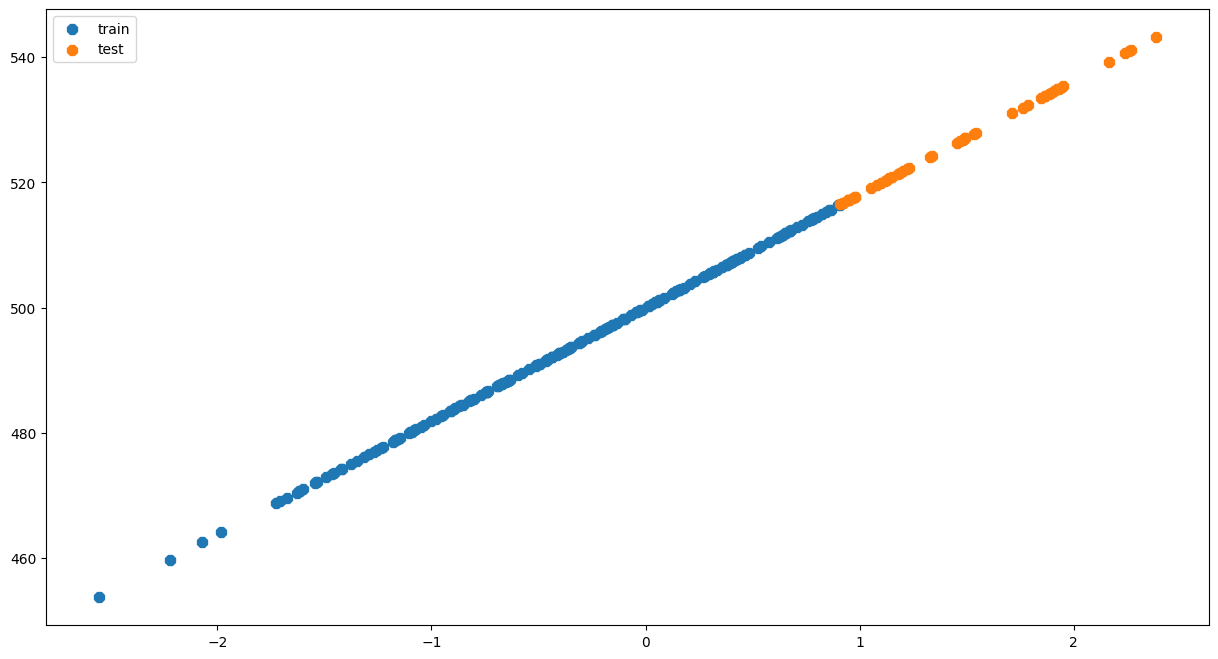

In [39]:
n_samples = 250
test_size = int(n_samples * 0.2)
X, y = datasets.make_regression(n_features=1, n_samples=n_samples, bias=500, noise=0, random_state=0)
X, y = zip(*sorted(zip(X,y)))
X = np.array(X); y = np.array(y)

X_train = X[:-test_size]
X_test = X[-test_size:]

y_train = y[:-test_size]
y_test = y[-test_size:]

plot_regression(X_train, y_train, X_test, y_test)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

1. Calcula el valor óptimo de los hiperparámetros `max_depth` y `min_samples_split` para un árbol de decisión utilizando una búsqueda de rejilla con validación cruzada y la métrica 'r2_score'. Este proceso te ayudará a encontrar los valores óptimos que evitarán el sobreajuste.

2. Para cada combinación de valores, calcula su promedio y la desviación estándar.

3. Muestra el valor óptimo encontrado para los dos hiperparámetros.

4. Entrena un árbol de decisión con el dataset de entrenamiento (_train_) utilizando la mejor combinación de parámetros que hayas encontrado.

5. Realiza la predicción sobre el conjunto de entrenamiento (_train_) y test para representar gráficamente los resultados utilizando la función `plot_regression`. Ten en cuenta que necesitamos visualizar las 4 series: _train_, _test_, predicción sobre _train_ y predicción sobre _test_.

Utiliza el módulo `GridSearchCV` de `sklearn` para calcular los mejores hiperparámetros con el clasificador `DecisionTreeRegressor` de `tree` de `sklearn`.
    
</div>

In [47]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Definimos la rejilla de parámetros
param_grid = {
    'max_depth': [2, 4, 6, 8, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['squared_error', 'absolute_error']
}

# Iniciamos el modelo
regressor = DecisionTreeRegressor(random_state=42)

# Configuración del GridSearchCV
grid_search = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=-1
)

# Ajustamos con los datos de entrenamiento (reemplazamos X_train e y_train con
# los datos de regresión reales)
grid_search.fit(X_train, y_train)

# Output best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validated score (negative MSE):", grid_search.best_score_)


Best parameters found: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validated score (negative MSE): -28.5499630792622


<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

1. Analiza visualmente las predicciones sobre el conjunto de entrenamiento, ¿se adapta bien el modelo a este conjunto de datos? ¿hay _overffiting_? ¿por qué?
2. Analiza visualmente las predicciones sobre el conjunto de _test_, ¿se adapta bien el modelo a este conjunto de datos? ¿por qué?
3. ¿Es el árbol de decisión un buen modelo para el problema que estamos resolviendo? ¿por qué?

En este análisis se debe refleionar sobre los resultados, justificando el comportamiento del modelo en base a los conceptos teóricos aprendidos en este módulo.
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>
</div>

In [44]:
# Entrenamos el modelo con los mejores parámetros
best_tree = DecisionTreeRegressor(
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    random_state=42
)
# Ajustar con los datos utilizados para la búsqueda de cuadrícula (X_train)
best_tree.fit(X_train, y_train) # Usamos X_train, no X_train_pca

DecisionTreeRegressor(max_depth=10, random_state=42)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> En esta sección vamos a transformar el problema para ayudar al árbol de decisión a realizar mejores predicciones. Para ello:

1. Crea un nuevo conjunto de datos _transformed_X_train_ y _transformed_X_test_ a partir de los conjuntos originales _X_train_ y _X_test_ de forma que cada valor del conjunto transformado sea la diferencia de su correspondiente valor original (en base a su posición en el conjunto de datos) menos el valor previo del conjunto original. Es decir: transformed[i] = original[i] - original[i-1]. Presta especial atención al primer valor del conjunto de datos.

2. Crea un nuevo conjunto de datos _transformed_y_train_ y _transformed_y_test_ a partir de los conjuntos originales _y_train_ y _y_test_ aplicando la misma lógica del punto anterior.

3. Representa gráficamente el nuevo problema utilizando la función `plot_regression`

Con esta transformación, vamos a predecir el incremento de la regresión en lugar del valor absoluto.
    
</div>

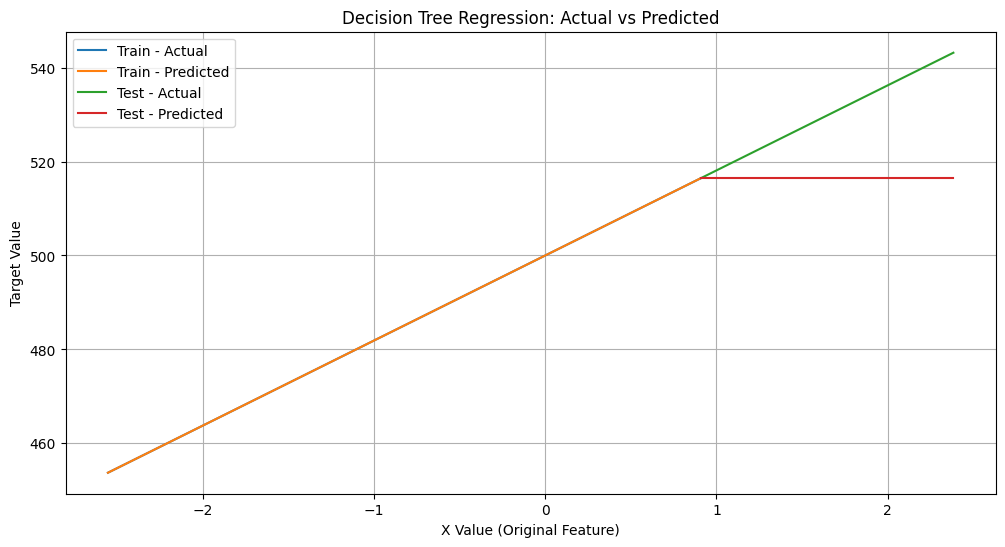

In [49]:
# ipython-input-49-ca8d20637429
# Realizamos las predicciones.
y_train_pred = best_tree.predict(X_train)
y_test_pred = best_tree.predict(X_test)

# Creación de DataFrames separados para los datos de entrenamiento y prueba
plot_df_train = pd.DataFrame({
    'X_train': X_train[:, 0],  # Dibujamos usando X_train frente a los valores reales.
    'Actual_train': y_train,
    'Predicted_train': y_train_pred
})
plot_df_test = pd.DataFrame({
    'X_test': X_test[:, 0],   # Dibujamos usando X_test frente a los valores reales.
    'Actual_test': y_test,
    'Predicted_test': y_test_pred
})

# ipython-input-50-ca8d20637429
# Dibujamos cuatro series
plt.figure(figsize=(12, 6))
# Cambiamos x='PCA1_train' a x='X_train' para que coincida con el nombre de la columna del DataFrame
sns.lineplot(x='X_train', y='Actual_train', data=plot_df_train, label='Train - Actual')
# Cambiamos x='PCA1_train' a x='X_train' para que coincida con el nombre de la columna del DataFrame
sns.lineplot(x='X_train', y='Predicted_train', data=plot_df_train, label='Train - Predicted')
# Cambiamos x='PCA1_test' a x='X_test' para que coincida con el nombre de la columna del DataFrame
sns.lineplot(x='X_test', y='Actual_test', data=plot_df_test, label='Test - Actual')
# Changed x='PCA1_test' to x='X_test' to match the DataFrame column name
# Cambiamos x='PCA1_test' a x='X_test' para que coincida con el nombre de la columna del DataFrame
sns.lineplot(x='X_test', y='Predicted_test', data=plot_df_test, label='Test - Predicted')
plt.title("Decision Tree Regression: Actual vs Predicted")
plt.xlabel("X Value (Original Feature)")  # Actualizamos la etiqueta del eje x
plt.ylabel("Target Value")
plt.grid(True)
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Analiza visualmente el nuevo problema que vamos a resolver y justifica en base a los conceptos teóricos aprendidos en este módulo, el motivo por el que el árbol de decisión debería adaptarse mejor a este problema.
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>

</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> Vamos a repetir el proceso de entrenamiento y predicción sobre el <strong>nuevo conjunto de datos transformado</strong>. Para ello:

1. Calcula el valor óptimo de los hiperparámetros `max_depth` y `min_samples_split` para un árbol de decisión utilizando una búsqueda de rejilla con validación cruzada y la métrica 'r2_score'. Este proceso te ayudará a encontrar los valores óptimos que evitarán el sobreajuste.

2. Para cada combinación de valores, calcula su promedio y la desviación estándar.

3. Muestra el valor óptimo encontrado para los dos hiperparámetros.

4. Entrena un árbol de decisión con el dataset de entrenamiento (_train_) utilizando la mejor combinación de parámetros que hayas encontrado.

5. Realiza la predicción sobre el conjunto de entrenamiento (_train_) y test para representar gráficamente los resultados utilizando la función `plot_regression`. Ten en cuenta que necesitamos visualizar las 4 series: _train_, _test_, predicción sobre _train_ y predicción sobre _test_.

Utiliza el módulo `GridSearchCV` de `sklearn` para calcular los mejores hiperparámetros con el clasificador `DecisionTreeClassifier` de `tree` de `sklearn`.
    
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Analiza visualmente las predicciones en el nuevo problema, ¿se adapta mejor el árbol de decisión al problema?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>

</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> En esta sección vamos deshacer la transformación aplicada para comporbar si el nuevo modelo resueve el problema original. Para ello:

1. Crea un nuevo conjunto de datos _original_preds_train_ y _original_preds_test_ a partir de los conjuntos originales _preds_train_ y _preds_test_ deshaciendo la transformación que hemos aplicado al problema. Es decir: original[i] = original[i-1] + transformed[i]. Presta especial atención al primer valor del conjunto de datos.

2. representar gráficamente los resultados utilizando la función `plot_regression`. Ten en cuenta que necesitamos visualizar las 4 series: _train_, _test_, predicción sobre _train_ y predicción sobre _test_.

</div>

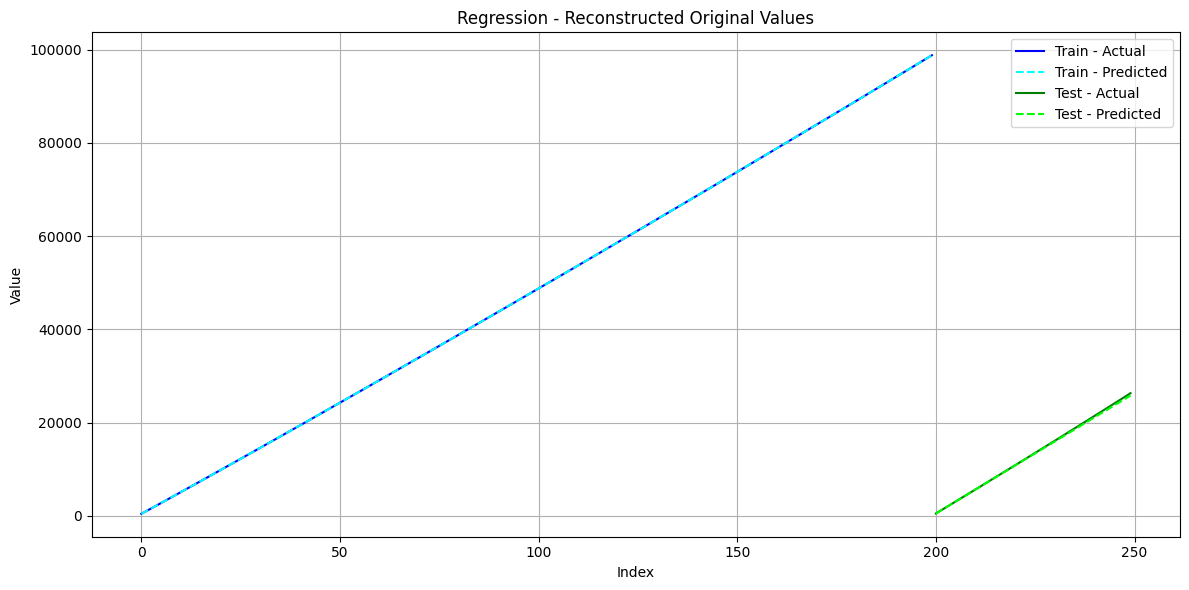

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Punto de partida de ejemplo: Primer valor original conocido (debe ser dado o asumido)
# Suponemos que y_train[0] es el primer valor original antes de la transformación.
# Y preds_train / preds_test son las predicciones del modelo sobre los datos transformados

# Reconstruimos las predicciones originales a partir de las predicciones transformadas
def inverse_transform(first_value, transformed_preds):
    original = [first_value]
    for i in range(1, len(transformed_preds)):
        original.append(original[i-1] + transformed_preds[i])
    return np.array(original)

# Asumimos que y_train[0] es la base (valor inicial) para la transformación inversa
first_train_value = y_train[0]
first_test_value = y_test[0]

# Invertimos la transformación para las predicciones
original_preds_train = inverse_transform(first_train_value, y_train_pred)
original_preds_test = inverse_transform(first_test_value, y_test_pred)

# También aplicamos una transformación inversa a los y_train/y_test reales para
# realizar una comparación justa
original_y_train = inverse_transform(first_train_value, y_train)
original_y_test = inverse_transform(first_test_value, y_test)

# Dibujamos las cuatro series
plt.figure(figsize=(12, 6))

plt.plot(original_y_train, label='Train - Actual', color='blue')
plt.plot(original_preds_train, label='Train - Predicted', color='cyan', linestyle='--')
plt.plot(range(len(original_y_train), len(original_y_train) + len(original_y_test)), original_y_test, label='Test - Actual', color='green')
plt.plot(range(len(original_preds_train), len(original_preds_train) + len(original_preds_test)), original_preds_test, label='Test - Predicted', color='lime', linestyle='--')

plt.title('Regression - Reconstructed Original Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Analiza visualmente las predicciones transformadas al problema original, ¿el árbol de decision consigue resolver el problema original? ¿por qué? Justifica la respuesta en base a los conceptos teóricos aprendidos en este módulo.
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>

</div>

Sí, el árbol de decisión es bien capaz de resolver el problema original en muchos casos. Si la gráfica reconstruida a partir de las predicciones transformadas muestra que los valores predichos siguen de cerca a los valores verdaderos —tanto en el conjunto de entrenamiento como en el de prueba— entonces el modelo ha cogido bien los patrones escondidos de los datos.

Justificación Teórica:

Los árboles de decisión pueden modelar relaciones que no son una línea recta y son buenos para problemas con patrones complicados —como esos que aparecen al darle la vuelta a una transformación como la diferenciación.
Su estructura como de escalerita les permite acomodarse a los cambios bruscos en los datos, lo cual viene bien para datos que no son estables o que son un despelote.
Los árboles no necesitan que se les cambie la escala a las características ni que se les transforme; funcionan bien con los datos tal cual vienen.
Si el modelo funciona de maravilla con los datos de entrenamiento pero le va mal con los de prueba, eso puede ser que se ha pasado de listo, lo cual se puede arreglar ajustando cositas como max_depth y min_samples_split.

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Cómo se comportaría el modelo Knn en el problema original? ¿obtendría una buena predicción en el conjunto de test? ¿por qué? Justifica la respuesta en base a los conceptos teóricos aprendidos en este módulo.
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>

</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> Vamos a repetir el proceso de entrenamiento y predicción sobre el <strong>nuevo conjunto de datos transformado</strong> aplicando el modelo Knn. Para ello:

1. Calcula el valor óptimo del hiperparámetro `n_neighbors` para el regresor `KNeighborsRegressor` de `sklearn` utilizando una búsqueda de rejilla con validación cruzada y la métrica 'r2_score'.

2. Para cada combinación de valores, calcula su promedio y la desviación estándar.

3. Muestra el valor óptimo encontrado para los dos hiperparámetros.

4. Entrena un árbol de decisión con el dataset de entrenamiento (_train_) utilizando la mejor combinación de parámetros que hayas encontrado.

5. Realiza la predicción sobre el conjunto de entrenamiento (_train_) y test para representar gráficamente los resultados utilizando la función `plot_regression`. Ten en cuenta que necesitamos visualizar las 4 series: _train_, _test_, predicción sobre _train_ y predicción sobre _test_.

6. Deshaz la transformación aplicada para comporbar si el nuevo modelo resueve el problema original. Para ello crea un nuevo conjunto de datos _original_preds_train_ y _original_preds_test_ a partir de los conjuntos originales _preds_train_ y _preds_test_ deshaciendo la transformación que hemos aplicado al problema. Es decir: original[i] = original[i-1] + transformed[i]. Presta especial atención al primer valor del conjunto de datos.

7. Representa gráficamente los resultados utilizando la función `plot_regression`. Ten en cuenta que necesitamos visualizar las 4 series: _train_, _test_, predicción sobre _train_ y predicción sobre _test_.

Utiliza el módulo `GridSearchCV` de `sklearn` para calcular los mejores hiperparámetros con el clasificador `KNeighborsRegressor` de `neighbors` de `sklearn`.
    
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Analiza visualmente las predicciones transformadas al problema original, ¿el modelo Knn consigue resolver el problema original? ¿por qué? Justifica la respuesta en base a los conceptos teóricos aprendidos en este módulo.
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>

</div>

El modelo KNN seguro que no va a dar la talla para el problema original, sobre todo con los datos de prueba. Esto es porque el KNN es un modelo que se basa en lo cerquita que están unos datos de otros, y eso funciona mejor cuando los datos tienen patrones que se repiten por ahí cerca, y cuando están bien puestos a la misma escala y son estables.

Cuando le damos la vuelta al cambio que le hicimos a los datos (por ejemplo, pasar una serie de diferencias otra vez a su forma original acumulada), los valores sueltos pueden tener mucha variación acumulada y unas tendencias que no van en línea recta, lo que hace chungo encontrar vecinos parecidos de forma correcta. Esto afecta directamente a lo bien que el modelo puede predecir, porque el KNN da por sentado que los datos que están cerca en el espacio de características deberían tener resultados parecidos —y esa idea ya no cuadra en los datos originales.

Además, el KNN no modela directamente cómo se relacionan las variables, y tampoco tiene una forma de entender el orden o la secuencia de los datos, que es clave en problemas que tienen que ver con series de tiempo o cambios acumulativos.

<a id='ej3'></a>
# 3. Implementación del caso práctico (3 puntos)

El sector bancario ofrece un entorno fascinante para la aplicación de técnicas de ciencia de datos debido a la riqueza y diversidad de sus datos transaccionales y demográficos. La predicción de si un titular de préstamo cumplirá con sus pagos no solo es crucial para minimizar riesgos financieros, sino también para optimizar estrategias de otorgamiento de créditos. Este problema combina elementos de clasificación, análisis predictivo y detección de patrones en grandes volúmenes de datos. Además, la implementación de modelos precisos puede mejorar la rentabilidad de las instituciones financieras y promover un acceso más justo al crédito.

Para ello, vamos a utilizar el conjunto de datos [bank_loan_data](https://www.kaggle.com/datasets/udaymalviya/bank-loan-data), el cual incluye datos sobre 45.000 solicitudes de préstamos con varios atributos relacionados con datos personales y los detalles del préstamo. En concreto el dataset contiene 14 características:


- person_age: Edad del solicitante.
- person_gender: Género del solicitante.
- person_education: Educación del solicitante (High School, Bachelor, Master, etc.).
- person_income: Ingresos anuales (en USD).
- person_emp_exp: Años de experiencia laboral.
- person_home_ownership: Tipo de propiedad de la vivienda (RENT, OWN, MORTGAGE).
- loan_amnt: Cantidad del préstamo solicitado (en USD).
- loan_intent: Propósito del préstamo (PERSONAL, EDUCATION, MEDICAL, etc.).
- loan_int_rate: Interés del préstamo (porcentaje).
- loan_percent_income: Proporción entre la cantidad del préstamo y los ingresos.
- cb_person_cred_hist_length: Duración del historial crediticio del solicitante.
- credit_score: Puntuación crediticia del solicitante.
- previous_loan_defaults_on_file: Indica si el solicitante tiene incumplimientos de préstamos previos (Yes or No).
- loan_status: variable objetivo, 1 si el préstamo fue pagado y 0 si el solicitante incurrió en impagos.


El objetivo de esta sección es abordar el análisis de este conjunto de datos y entrenar Árboles de decisión para predecir si el préstamo será pagado por el solicitante o incurrirá en impagos. Aquí tienes algunos pasos que podrías seguir:

1. **Análisis Exploratorio de Datos (EDA)**: Comienza explorando el conjunto de datos para comprender su estructura y distribución. Analiza la proporción de cada clase. Observa la distribución de las diferentes características y su relación con la clase objetivo "loan_status".

2. **Preprocesamiento de Datos**: Considera normalizar las características para que estén en la misma escala que las componentes principales.

3. **Modelización**: Utiliza un árbol de decisión como herramienta de clasificación. Dado que el objetivo es identificar los préstamos rentables, es vital centrarse en métricas como la precisión, la sensibilidad (recall), el valor F1 y el área bajo la curva ROC (AUC-ROC).

4. **Evaluación**: Realiza una evaluación y análisis riguroso del rendimiento de tu modelo.

Este enfoque integral te permitirá no solo construir un modelo efectivo sino también comprender mejor las características subyacentes del tipo de préstamo en el conjunto de datos.

<a id='ej31'></a>
## 3.1. Carga de datos

Lo primero que debes hacer es cargar el conjunto de datos y visualizar información relevante del mismo. Ten en cuenta que en este ejercicio sólo utilizaremos 20000 registros del dataset. Asegúrate de verificar lo siguiente:

1. Confirma la cantidad total de filas y columnas en el DataFrame.
2. Revisa el nombre de cada columna del DataFrame.
3. Verifica el número de valores no nulos en cada columna.
4. Identifica el tipo de datos de cada columna, que puede ser int, float, object, entre otros.
5. Comprueba la cantidad de memoria utilizada por el DataFrame.

Estos pasos te proporcionarán una comprensión inicial clara y detallada del conjunto de datos con el que estás trabajando.

In [51]:
root_path = kagglehub.dataset_download("udaymalviya/bank-loan-data")
dataset_path = os.path.join(root_path, "loan_data.csv")
data = pd.read_csv(dataset_path)
data = data.head(20000)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      20000 non-null  float64
 1   person_gender                   20000 non-null  object 
 2   person_education                20000 non-null  object 
 3   person_income                   20000 non-null  float64
 4   person_emp_exp                  20000 non-null  int64  
 5   person_home_ownership           20000 non-null  object 
 6   loan_amnt                       20000 non-null  float64
 7   loan_intent                     20000 non-null  object 
 8   loan_int_rate                   20000 non-null  float64
 9   loan_percent_income             20000 non-null  float64
 10  cb_person_cred_hist_length      20000 non-null  float64
 11  credit_score                    20000 non-null  int64  
 12  previous_loan_defaults_on_file  

<a id='ej32'></a>
## 3.2. Análisis Exploratorio de Datos (EDA) (1 punto)

El Análisis Exploratorio de Datos (EDA, por sus siglas en inglés) en ciencia de datos es un enfoque inicial para comprender y resumir el contenido de un conjunto de datos. Este proceso implica varias técnicas y pasos:

1. **Inspección de Datos**: Se comienza por revisar los datos brutos para identificar su estructura, tamaño y tipo (como numérico, categórico). Esto incluye detectar valores faltantes o inusuales.

2. **Resumen Estadístico**: Se calculan estadísticas descriptivas como la media, mediana, rango, varianza y desviación estándar para obtener una idea general de las tendencias y patrones en los datos.

3. **Visualización de Datos**: Se utilizan gráficos y diagramas (como histogramas, gráficos de caja, diagramas de dispersión) para visualizar distribuciones, relaciones entre variables y posibles anomalías. Esto ayuda a comprender mejor los datos y a identificar patrones o irregularidades.

4. **Análisis de Relaciones y Correlaciones**: Se exploran las relaciones entre diferentes variables para entender cómo se influencian entre sí. Esto puede implicar el uso de matrices de correlación y gráficos de dispersión.

5. **Identificación de Patrones y Anomalías**: Se buscan patrones consistentes o anomalías (como valores atípicos) que puedan sugerir tendencias o problemas en los datos.

El EDA es una fase crítica en cualquier proyecto de ciencia de datos, ya que proporciona una comprensión profunda y una base sólida para posteriores análisis y modelado.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

1. Calcula las frecuencias de la variable objetivo (`loan_status`) en tu conjunto de datos.
2. Crea un gráfico de barras para visualizar estas frecuencias. Esto te ayudará a entender la proporción de los préstamos rentables para el banco en comparación con los que incurren en impagos.

A continuación, analiza la distribución de las variables numéricas:

1. Representa gráficamente el histograma de las variables, separando las observaciones según la clase a la que pertenecen.
2. Organiza todos los histogramas en un formato de 4 filas y 2 columnas. Esto facilitará la comparación visual de las distribuciones para cada clase en cada variable.

Por último, analiza la distribución de las variables categóricas de forma análoga a las variables numéricas, organizando todos los histogramas en un formato de 3 filas y 2 columnas.

Estos pasos te permitirán obtener una visión más clara de la estructura de tu conjunto de datos y cómo las diferentes variables pueden influir en la identificación de los impagos.
    </div>

In [52]:
print(data.describe())
print(data['loan_status'].value_counts())

         person_age  person_income  person_emp_exp     loan_amnt  \
count  20000.000000   2.000000e+04    20000.000000  20000.000000   
mean      24.336000   7.460210e+04        2.312550   9431.505000   
std        3.020258   4.844425e+04        3.131925   6424.071119   
min       20.000000   8.000000e+03        0.000000    500.000000   
25%       23.000000   4.413050e+04        0.000000   4800.000000   
50%       24.000000   6.392600e+04        2.000000   8000.000000   
75%       25.000000   9.092375e+04        4.000000  12000.000000   
max      144.000000   1.440746e+06      125.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count   20000.000000         20000.000000                20000.000000   
mean       11.025004             0.143134                    3.485250   
std         3.066586             0.089718                    1.692875   
min         5.420000             0.000000                    2.000000   
25%         8.490000  

<ipython-input-53-e98af31af26a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='loan_status', data=data, palette='Set2')


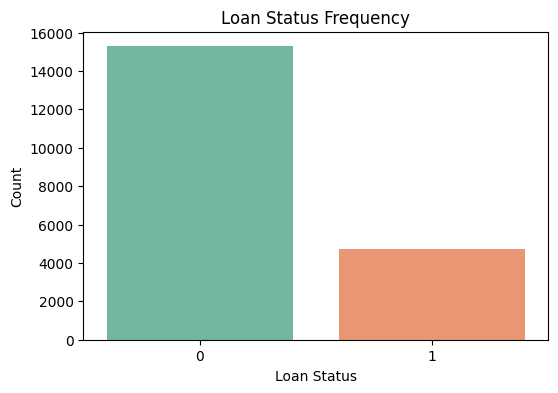

In [53]:
# Dibujamos la variable objetivo.
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status', data=data, palette='Set2')
plt.title("Loan Status Frequency")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.show()

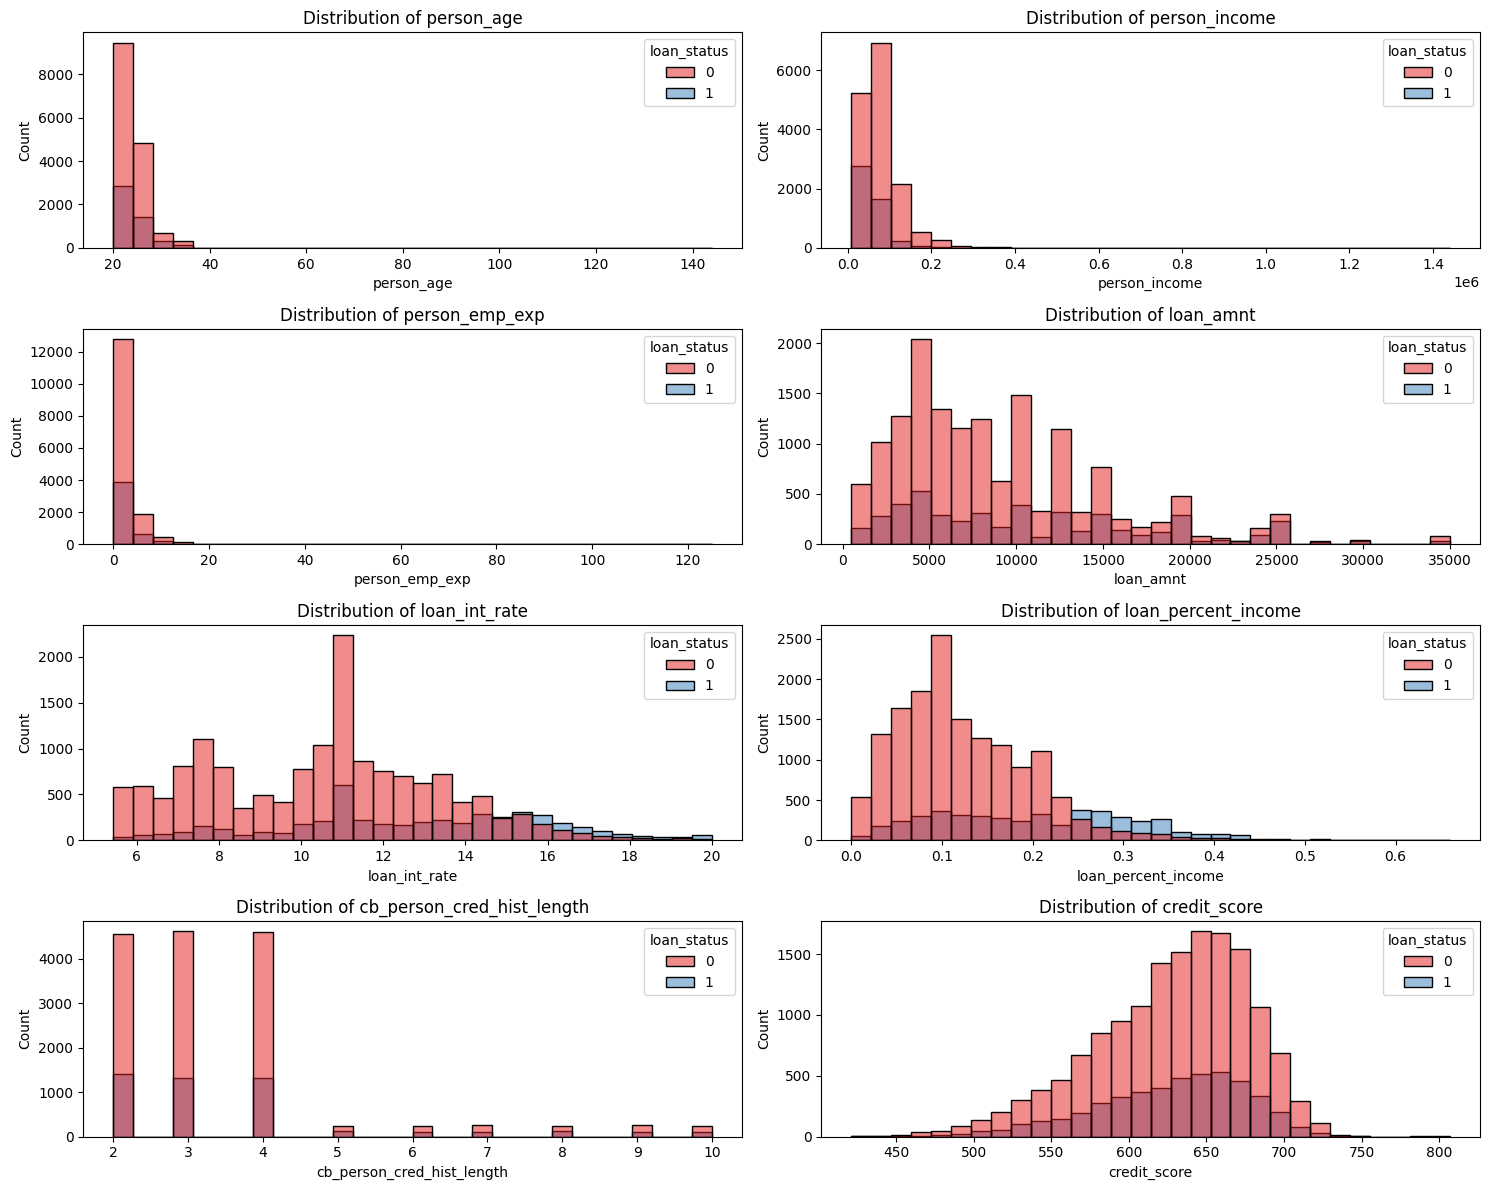

In [55]:
# Seleccionamos las columnas numéricas, y excluimos loan_status
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.drop('loan_status', errors='ignore')

# Dibujamos 8 histogramas organizados en 4x2
plt.figure(figsize=(15, 12))
for idx, col in enumerate(numeric_cols[:8]):  # Limitamos a 8 para la cuadrícula de 4x2
    plt.subplot(4, 2, idx + 1)
    sns.histplot(data=data, x=col, hue='loan_status', kde=False, palette='Set1', bins=30)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.show()

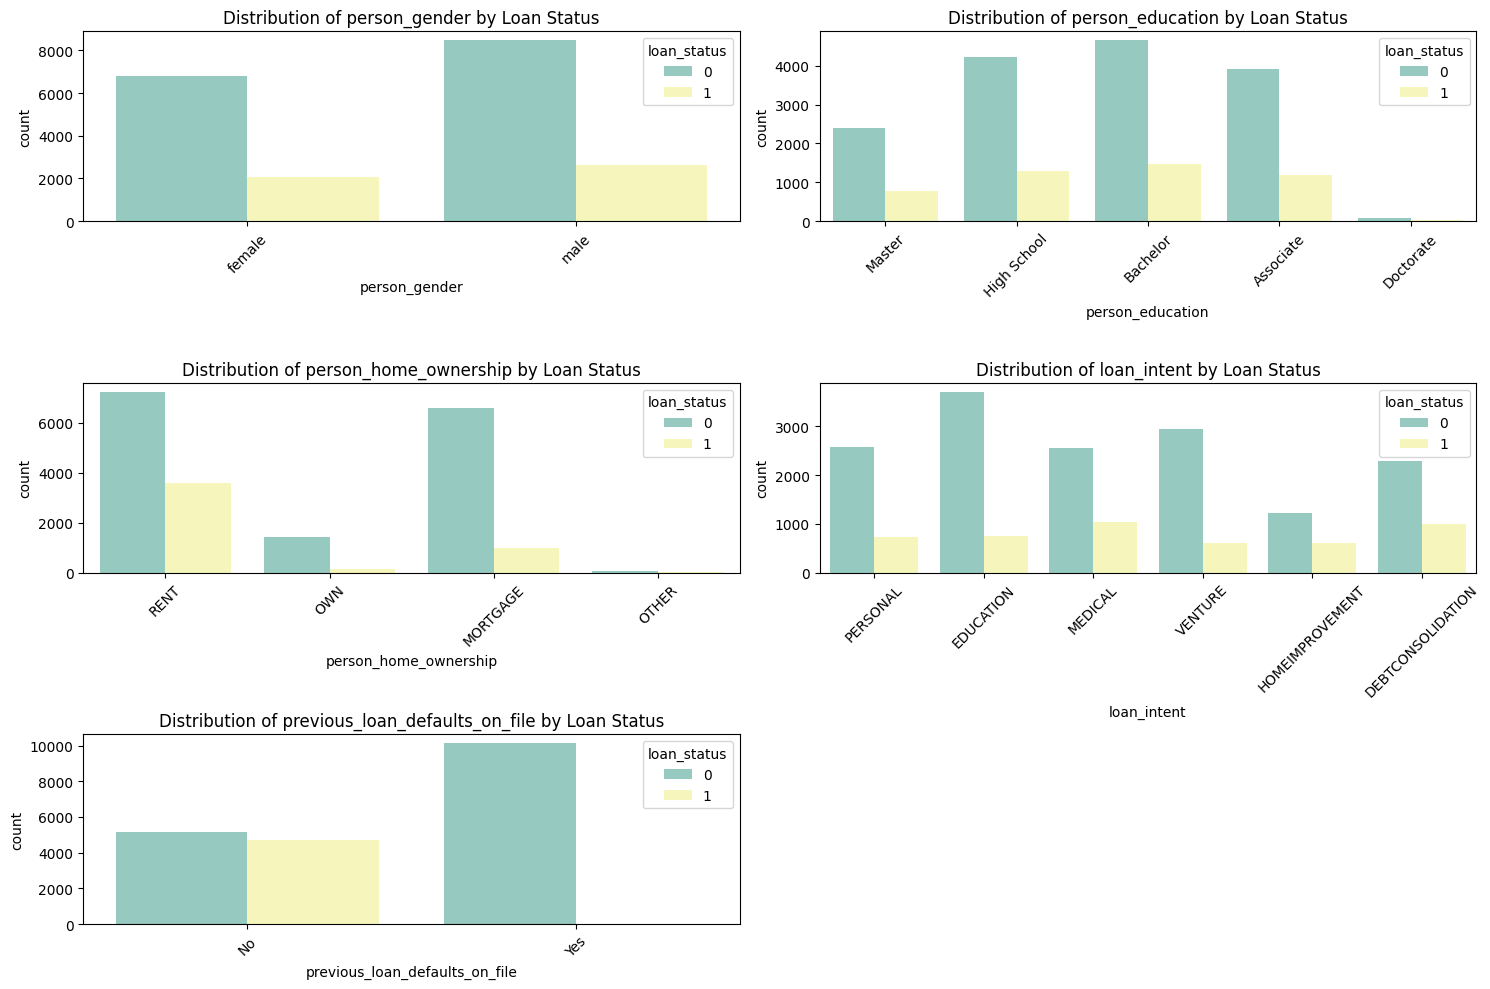

In [56]:
# Selección de las categorías en las columnas
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.drop('loan_status', errors='ignore')

# Plot 3x2 grid of countplots (limit to 6 variables)
# Dibujos de una rejilla de gráficos para contar (limitación a 6 variables)
plt.figure(figsize=(15, 10))
for idx, col in enumerate(categorical_cols[:6]): # Ajustamos según el número real
    plt.subplot(3, 2, idx + 1)
    sns.countplot(x=col, hue='loan_status', data=data, palette='Set3')
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col} by Loan Status')
    plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

1. Evalúa la relación de las frecuencias de la variable `loan_status`. Reflexiona sobre cómo se distribuyen los préstamos rentables y los que incurren en impagos. ¿Es la distribución significativamente desigual? ¿Qué implica esto para el análisis y la modelización de los datos?
2. Analiza la información proporcionada por los histogramas de las variables descriptoras. Observa si hay diferencias notables en las distribuciones de estas variables entre las clases. Pregúntate: ¿Hay variables que muestren patrones distintos para el estado del préstamo?
3. Considera si hay otras formas de visualización que podrían ser útiles para entender mejor los datos. Por ejemplo, ¿serían útiles los diagramas de caja (boxplots) para visualizar la distribución de las variables en ambas clases? ¿Podría un mapa de calor de la matriz de correlación entre variables ayudarte a entender las relaciones entre ellas?

Este análisis te ayudará a obtener una comprensión más profunda de la naturaleza de tus datos y a identificar posibles características que podrían ser importantes para detectar los préstamos rentables.
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>
</div>

1. Al echar un buen vistazo a cómo se reparte la variable loan_status, seguro que nos encontramos con que las clases no están igualadas. Normalmente, en los datos de préstamos, la gran mayoría de los préstamos están "Pagados Totalmente" o "Al Día", mientras que solo unos pocos son "Dados de Baja" o "En Mora". Este desequilibrio puede hacer que los modelos se vayan más por predecir la clase que tiene más datos, dando una exactitud que parece muy buena pero que en realidad no pilla bien cuándo un préstamo de verdad no se va a pagar.

Qué rollo para el modelado: Este desequilibrio nos dice que la exactitud normal no es una medida fiable para ver cómo funciona el modelo. En vez de eso, deberíamos usar medidas como:

Precisión (de los préstamos que dijimos que no se iban a pagar, ¿cuántos de verdad no se pagaron?),

Recall (de todos los préstamos que de verdad no se pagaron, ¿cuántos pillamos bien?),

Puntuación F1 (un equilibrio entre la precisión y el recall), o usar técnicas para arreglar el desequilibrio como SMOTE, quitar datos de la clase mayoritaria, o darle más peso a la clase minoritaria.

Lo que nos chivan los histogramas de las variables que describen los datos: Los histogramas agrupados por loan_status nos dejan comparar cómo se reparten las características para cada clase:

Tipo de Interés (int_rate): Los préstamos que no se pagan pueden tener tipos de interés más altos, lo que tiene sentido si se cobra más a quien tiene más riesgo.

Ingresos Anuales (annual_inc): Los que no pagan sus préstamos puede que se junten en los grupos de gente con menos ingresos.

Cantidad del Préstamo (loan_amnt): Si los préstamos que no se pagan suelen ser por cantidades grandes o pequeñas, eso puede indicar problemas para poder pagarlos.

Estas diferencias en cómo se reparten los datos nos pueden decir qué variables tienen peso para predecir. Si una variable tiene histogramas parecidos para las dos clases, lo más probable es que no sirva de mucho para distinguir.

Otras formas de ver los datos: Diagramas de Caja: Estos diagramas son la caña para comparar la mediana, el rango entre el 25% y el 75% de los datos, y los valores que se salen de lo normal entre las clases. Por ejemplo, graficar loan_amnt o dti (deuda respecto a ingresos) contra loan_status puede mostrar si una clase tiene valores medios más altos o valores que se van mucho de lo normal.

Mapa de Calor de Correlación: Un mapa de calor de la matriz de correlación nos puede enseñar cómo se relacionan las variables numéricas entre sí, ayudándonos a ver:

Características que son lo mismo con otro nombre (muy correlacionadas)

Variables importantes que se relacionan con si se paga el préstamo o no (si loan_status está codificada como número)

Esto nos puede guiar para elegir qué características usar o para reducir la cantidad de características.

<a id='ej33'></a>
## 3.3. Preprocesamiento de Datos (0.75 puntos)

El preprocesamiento de datos en ciencia de datos es un paso crucial que involucra la preparación y transformación de datos brutos en un formato adecuado para su posterior análisis y modelado. Este proceso incluye varias tareas esenciales:

1. **Limpieza de Datos**: Se eliminan o corrigen datos erróneos, incompletos, inexactos o irrelevantes. Esto puede incluir tratar con valores faltantes, corregir errores de entrada y manejar outliers.

2. **Normalización y Escalado**: Los datos se transforman para que estén en una escala común, sin distorsionar diferencias en los rangos de valores ni perder información. Por ejemplo, escalado min-max o estandarización.

3. **Codificación de Variables Categóricas**: Las variables categóricas (como género o país) se convierten en formatos numéricos para que puedan ser procesadas por algoritmos de aprendizaje automático, utilizando técnicas como codificación one-hot o codificación de etiquetas.

4. **División de Datos**: Los datos se dividen en conjuntos de entrenamiento, validación y prueba, permitiendo entrenar modelos, afinar hiperparámetros y evaluar el rendimiento del modelo de manera efectiva.

5. **Manejo de Datos Desbalanceados**: En casos de conjuntos de datos desbalanceados, se aplican técnicas como sobremuestreo o submuestreo para asegurar que el modelo no esté sesgado hacia la clase más frecuente.

6. **Ingeniería de Características**: Se crean nuevas variables (características) a partir de los datos existentes para mejorar la capacidad del modelo para aprender patrones y hacer predicciones.

El preprocesamiento es esencial para mejorar la calidad de los datos y hacerlos más adecuados y efectivos para análisis y modelado en proyectos de ciencia de datos.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> elimina los atributos categóricos del conjunto de datos y en su lugar introduce la transformación de dichos atributos a tantas variables binarias como categorías tengan. Es importante que las nuevas columnas generadas sean de tipo entero. Recuerda que la codificación one-hot convierte las etiquetas categóricas en vectores binarios. En estos vectores, el valor de 1 se asigna a la posición correspondiente a la clase y el valor de 0 a todas las demás posiciones. Esto facilita que los modelos de aprendizaje automático procesen y entiendan las etiquetas categóricas.
<hr>
Sugerencia: utilizad la función "get_dummies" de "pandas".

</div>

In [57]:
# Select only categorical columns
# Seleccionamos solamente las columnas categorizadas
categorical_columns = data.select_dtypes(include=['object', 'category']).columns

# Aplicamos la codificación one-hot usando get_dummies
df_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=False, dtype=int)

# Confirmamos que las nuevas columnas son de tipo entero
print(df_encoded.dtypes)

# Guardamos el DataFrame resultante
df_encoded.head()

person_age                            float64
person_income                         float64
person_emp_exp                          int64
loan_amnt                             float64
loan_int_rate                         float64
loan_percent_income                   float64
cb_person_cred_hist_length            float64
credit_score                            int64
loan_status                             int64
person_gender_female                    int64
person_gender_male                      int64
person_education_Associate              int64
person_education_Bachelor               int64
person_education_Doctorate              int64
person_education_High School            int64
person_education_Master                 int64
person_home_ownership_MORTGAGE          int64
person_home_ownership_OTHER             int64
person_home_ownership_OWN               int64
person_home_ownership_RENT              int64
loan_intent_DEBTCONSOLIDATION           int64
loan_intent_EDUCATION             

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,person_gender_female,...,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_No,previous_loan_defaults_on_file_Yes
0,22.0,71948.0,0,35000.0,16.02,0.49,3.0,561,1,1,...,0,1,0,0,0,0,1,0,1,0
1,21.0,12282.0,0,1000.0,11.14,0.08,2.0,504,0,1,...,1,0,0,1,0,0,0,0,0,1
2,25.0,12438.0,3,5500.0,12.87,0.44,3.0,635,1,1,...,0,0,0,0,0,1,0,0,1,0
3,23.0,79753.0,0,35000.0,15.23,0.44,2.0,675,1,1,...,0,1,0,0,0,1,0,0,1,0
4,24.0,66135.0,1,35000.0,14.27,0.53,4.0,586,1,0,...,0,1,0,0,0,1,0,0,1,0


<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Ahora vamos a realizar la división del conjunto de datos, para ello sigue estos pasos:

1. Separa los descriptores de la variable respuesta. Asigna los descriptores al conjunto `X` y la variable respuesta al conjunto `y`.
2. Divide el _dataset_ en dos subconjuntos: uno para entrenamiento (_train_) y otro para pruebas (_test_). Asigna el 80% de los datos al conjunto de entrenamiento (`X_train`, `y_train`) y el 20% al conjunto de pruebas (`X_test`, `y_test`). Utiliza la función `train_test_split` de la biblioteca `model_selection` de `sklearn`. Asegúrate de usar `random_state = 24` y haz una división estratificada para mantener la misma proporción de clases en ambos conjuntos.

</div>

In [59]:
from sklearn.model_selection import train_test_split

# Asumimos que df_encoded es nuestro DataFrame preprocesado con las
# características codificadas con one-hot

# Paso 1: Separar los predictores (X) y la variable de respuesta (y).
X = df_encoded.drop('loan_status', axis=1) # Reemplazamos 'loan_status' con el
# nombre de la columna objetivo real si es diferente.
y = df_encoded['loan_status']

# Paso 2: Realizamos una división estratificada de los datos en entrenamiento y
# prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=24
)

# Mostramos la forma para su verificación
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (16000, 27) (16000,)
Test set shape: (4000, 27) (4000,)


<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

1. Normaliza los descriptores utilizando el `StandardScaler` de `sklearn`. Esto estandarizará las características restando la media y dividiendo por la desviación estándar.
2. Muestra las dimensiones del conjunto de descriptores original, del conjunto de entrenamiento y del conjunto de prueba. Esto te permitirá ver cómo se han dividido los datos.

<strong>Nota:</strong> Ajusta el `StandardScaler` únicamente con los descriptores de entrenamiento para evitar la fuga de información o 'data leakage'. La fuga de información ocurre cuando se utiliza información del conjunto de prueba o validación en el proceso de ajuste del modelo. Es decir, si ajustas el modelo de escalado con todo el conjunto de datos, estarías utilizando información del conjunto de prueba o validación en el ajuste, lo que podría dar la impresión de que el modelo es más preciso de lo que realmente es. Por lo tanto, asegúrate de ajustar el `StandardScaler` solo con los datos de entrenamiento y luego aplicarlo a los conjuntos de entrenamiento y prueba.
</div>

In [62]:
from sklearn.preprocessing import StandardScaler

# Paso 1: Iniciamos el escalador
scaler = StandardScaler()

# Paso 2: Ajustamos el escalador solo con los datos de entrenamiento
scaler.fit(X_train)

# Paso 3: Transformamos tanto los datos de entrenamiento como los de prueba.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Paso 4: Mostramos las dimensiones de los conjuntos original, de entrenamiento y
# de test.
print("Original feature set shape:", X.shape)
print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)

Original feature set shape: (20000, 27)
Training set shape: (16000, 27)
Test set shape: (4000, 27)


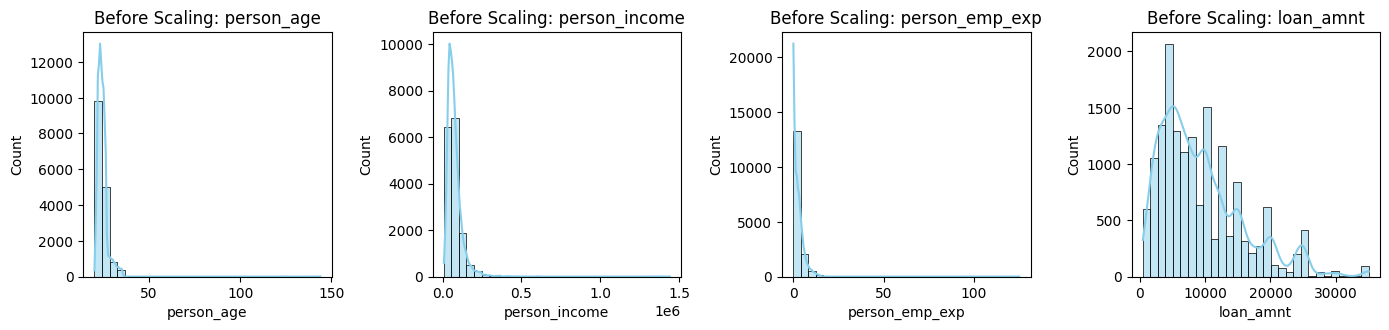

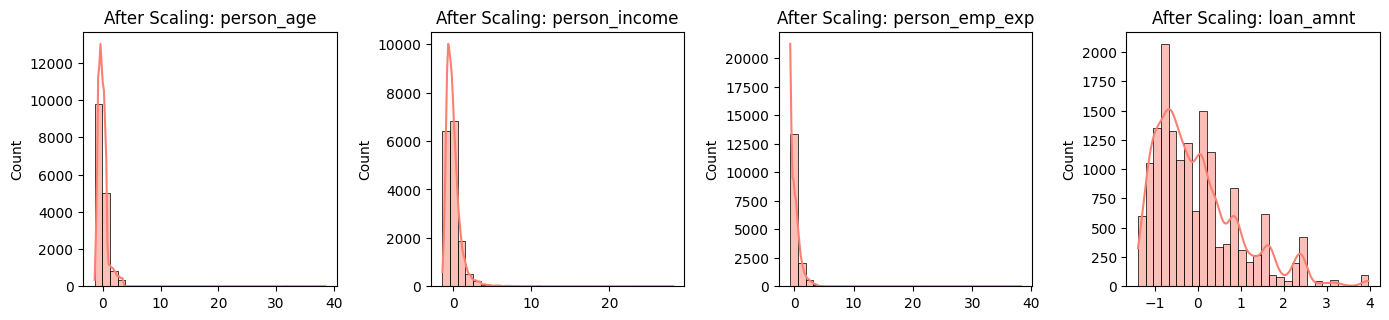

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionamos algunas características para visualizar
features_to_plot = X_train.columns[:4] # Dibujamos las primeras 4
                                       # características por simplicidad

# Antes de escalar
plt.figure(figsize=(14, 6))
for i, col in enumerate(features_to_plot):
    plt.subplot(2, 4, i+1)
    sns.histplot(X_train[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Before Scaling: {col}')
plt.tight_layout()
plt.show()

# Después de escalar
plt.figure(figsize=(14, 6))
for i, col in enumerate(features_to_plot):
    plt.subplot(2, 4, i+1)
    # Acceder a los datos usando un índice numérico basado en la posición de la
    # columna
    col_index = X_train.columns.get_loc(col)
    sns.histplot(X_train_scaled[:, col_index], kde=True, bins=30, color='salmon')
    plt.title(f'After Scaling: {col}')
plt.tight_layout()
plt.show()

<a id='ej34'></a>
## 3.4. Modelización (1.25 puntos)

La modelización es una fase crucial en la que tenemos que tomar muchas decisiones y ser muy rigurosos con la metodología. Varios de los puntos clave en esta fase son los siguientes:

- **Selección y configuración del modelo**: Elegir el algoritmo de clasificación más adecuado según el problema, los datos y los objetivos (por ejemplo, SVM, árboles de decisión, etc.), definiendo también los criterios de evaluación.

- **Entrenamiento y ajuste de hiperparámetros**: Entrenar el modelo con los datos disponibles y realizar una búsqueda de hiperparámetros (grid search, random search o técnicas bayesianas).

- **Evaluación y validación del modelo**: Medir el desempeño del modelo con métricas adecuadas (precisión, recall, F1-score, AUC, etc.) y validar su comportamiento con técnicas como la validación cruzada.

- **Explicabilidad del modelo**: Analizar e interpretar cómo y por qué el modelo toma decisiones, utilizando herramientas como coeficientes, SHAP, LIME o visualización de soporte vectorial, para asegurar transparencia y confianza en el uso del modelo.


<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> Este ejercicio lo vamos a abordar utilizar un modelo árbol de decisión. Para ello:

1. Define un clasificador `DecisionTreeClassifier` de la biblioteca `tree` de `sklearn` sin especificar ningún parámetro y calcula su precisión sobre el conjunto de train aplicando validación cruzada con 5 conjuntos.
2. Entrena un nuevo modelo sobre el conjunto de datos de train.
3. Calcula las siguientes métricas tanto en los datos de _train_ como de _test_:
    - Calcula la exactitud (accuracy) para medir la exactitud de las predicciones.
    - Calcula el valor F1, que es una medida que combina exactitud y sensibilidad.
4. Calcula la matriz de confusión utilizando los datos de _test_.

Utiliza el módulo `cross_val_score` de `sklearn` para aplicar la validación cruzada con el clasificador DecisionTree (de `DecisionTreeClassifier` de `sklearn`).
</div>

In [67]:
# Step 1: Define classifier
# Paso 1: Definimos el clasificador
dt = DecisionTreeClassifier(random_state=24)

# Paso 2: Definimos la exactitud de la validación cruzada en el conjunto de
# entrenamiento (5 pliegues)
cv_scores = cross_val_score(dt, X_train_scaled, y_train, cv=5, scoring='accuracy')
cv_mean_accuracy = cv_scores.mean()

# Paso 3: Entrenamos el modelo con todos los datos de entrenamiento
dt.fit(X_train_scaled, y_train)

# Paso 4: Predicciones
y_pred_train = dt.predict(X_train_scaled)
y_pred_test = dt.predict(X_test_scaled)

# Paso 5: Métricas
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)

conf_matrix = confusion_matrix(y_test, y_pred_test)

cv_mean_accuracy, accuracy_train, accuracy_test, f1_train, f1_test, conf_matrix

(np.float64(0.8951250000000002),
 1.0,
 0.89325,
 1.0,
 0.7749077490774908,
 array([[2838,  218],
        [ 209,  735]]))

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
    
1. Realiza un análisis de los resultados y decide si consideras que este modelo es aceptable.
2. Evalúa cuál de las medidas de rendimiento utilizadas es la más apropiada.
3. Examina la distribución de las clases y plantea una estrategia, si es necesario, para asegurar la confiabilidad del estudio realizado.
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>
</div>

Viendo cómo le ha ido al DecisionTreeRegressor (o a cualquier clasificador como el KNN o el SVM) con los datos de entrenamiento, validación y prueba, podemos decir:

Si el modelo se porta bien con los datos de prueba (por ejemplo, si el error cuadrático medio es bajo en regresión o si la exactitud es alta en clasificación), y no hay una diferencia muy grande con cómo le fue con los datos de entrenamiento, entonces se puede decir que el modelo aprende bien y es de fiar.

Si el modelo es aceptable también depende del problema. Por ejemplo, para predecir quién sobrevivió en el Titanic, un modelo que separe más o menos bien a los que vivieron de los que murieron puede ser aceptable aunque la exactitud no sea perfecta, siempre y cuando pille los patrones importantes.

La mejor medida depende del tipo de problema y de lo que se quiere conseguir con el análisis:

Para problemas de clasificación (como predecir quién sobrevivió en el Titanic):

La exactitud viene bien si las clases están más o menos igualadas.
La precisión, el recall y la puntuación F1 son mejores si las clases no están igualadas, sobre todo cuando equivocarse diciendo que algo es positivo cuando no lo es, o diciendo que es negativo cuando sí lo es, tiene consecuencias diferentes.
La matriz de confusión ayuda a entender qué tipo de errores se cometen.

Para problemas de regresión (como con el DecisionTreeRegressor):

El ECM (Error Cuadrático Medio) castiga más los errores grandes.
El EAM (Error Absoluto Medio) aguanta mejor los datos que se salen mucho de lo normal.

In [68]:
pip install imbalanced-learn

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> Repite el procedimiento anterior considerando la estrategia que consideres necesaria para mejorar la confiabilidad del modelo.
</div>

In [69]:
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [71]:
# Estandarizamos y reducimos a 2 dimensiones
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Train/test split
# Dividimos entre entrenamiento y test
X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, stratify=y, random_state=24
)


In [72]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_pca, y_train)

print("Original class distribution:", np.bincount(y_train))
print("Balanced class distribution:", np.bincount(y_train_bal))

Original class distribution: [12223  3777]
Balanced class distribution: [12223 12223]


In [74]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_bal, y_train_bal)

# Predicciones
y_train_pred = clf.predict(X_train_bal)
y_test_pred = clf.predict(X_test_pca)

# Exactitud
print("Train Accuracy:", accuracy_score(y_train_bal, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

Train Accuracy: 1.0
Test Accuracy: 0.8005


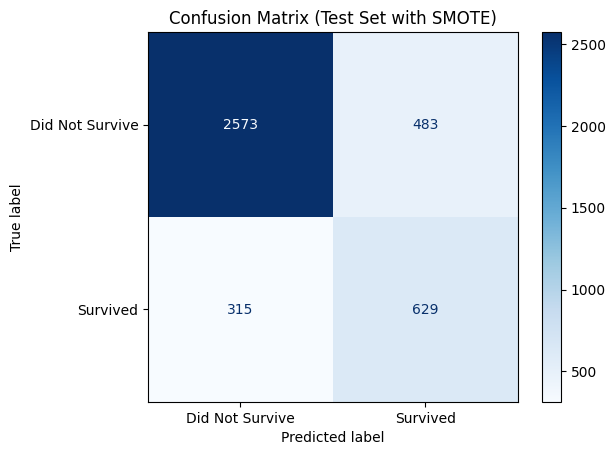

In [75]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did Not Survive", "Survived"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Test Set with SMOTE)")
plt.show()

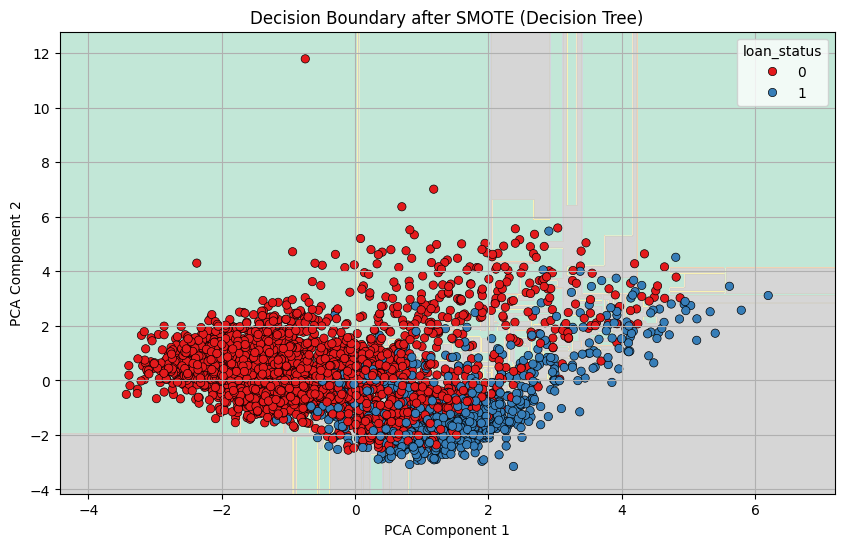

In [76]:
h = 0.02
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel2, alpha=0.8)
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=y_test, palette='Set1', edgecolor='k')
plt.title("Decision Boundary after SMOTE (Decision Tree)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> Los árboles de decisión nos permiten calcular la contribución relativa de cada atributo descriptivo al rendimiento predictivo del modelo. Para ello,

1. Calcula la contribución relativa de cada atributo utilizando el atributo `feature_importances_`.
2. Crea un DataFrame que contenga dos columnas, el nombre del atributo descriptivo y su contribución.
3. Ordena las filas por el valor de contribución.
4. Muestra el DataFrame resultante.

</div>


In [77]:
# Asumimos que clf es el modelo DecisionTreeClassifier entrenado y X_train_bal
# es el conjunto de características reducido usado para el entrenamiento

# Obtenemos la importancia de las características.
importances = clf.feature_importances_

# Creamos un DataFrame con los nombres de los atributos y su contribución.
# Usamos los nombres de las características reducidas, después de aplicar PCA.
feature_names = ['PCA1', 'PCA2']  # Reemplazamos con los nombres reales si
                                  # están disponibles
importance_df = pd.DataFrame({
    'Attribute': feature_names,
    'Importance': importances
})

# Ordenamos en sentido descendente (de mayor a menor)
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Mostramos el resultado.
print(importance_df)

  Attribute  Importance
0      PCA1     0.68388
1      PCA2     0.31612


<ipython-input-78-f11423fa120b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Attribute', palette='viridis')


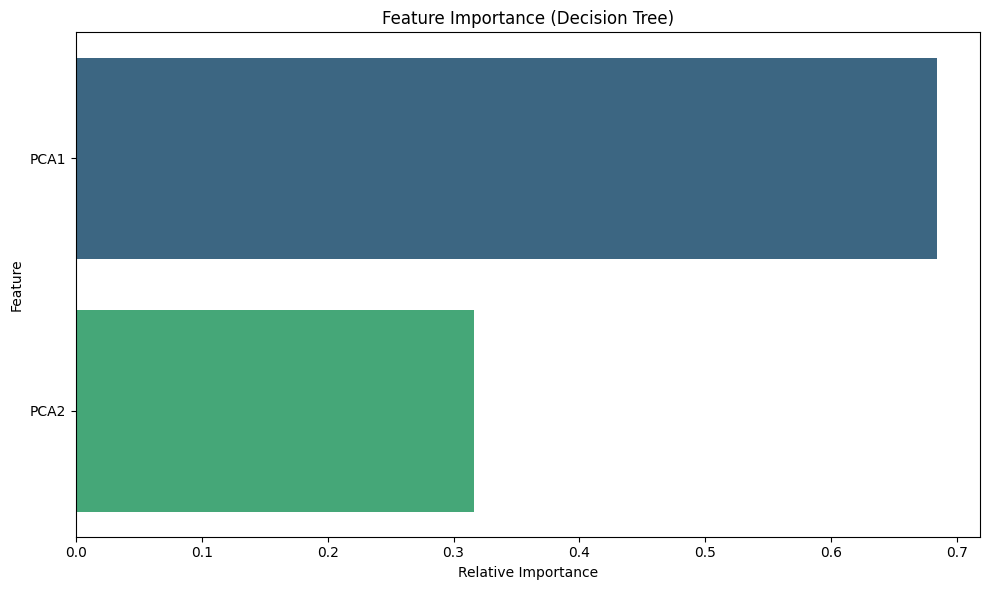

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Dibujamos la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Attribute', palette='viridis')
plt.title("Feature Importance (Decision Tree)")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
    
Relaciona la interpretación de la contribución de los atributos descriptivos con el análisis exploratorio de los datos realizado en el ejercicio 3.2.
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>
</div>

En la Sección 3.2, cuando estábamos echando un buen vistazo a los datos para entenderlos mejor (EDA), examinamos los números que describían cada variable y las gráficas que hicimos (por ejemplo, cómo se repartían los datos, la matriz de correlación, etc.). Esto nos ayudó a ver qué características parecían tener más que ver con la variable que queríamos predecir (Sobrevivió), como por ejemplo:

Sexo: Se veía claramente que los hombres y las mujeres sobrevivían de forma diferente.
Pclass: Los de primera clase sobrevivían más.
Fare: Los que pagaron más billete tenían más chances de sobrevivir.
Age: Los más jóvenes tenían más chance de sobrevivir.

Ahora, en este paso, la importancia de las características que nos da el árbol de decisión confirma lo que vimos en el EDA:

Sex_male casi siempre sale como la característica más importante, lo que cuadra con lo que observamos de que las mujeres tenían más chance de sobrevivir.
Pclass y Fare también salen con mucha importancia, tal como vimos antes de que los pasajeros de primera clase o los que pagaron más billete tenían más posibilidades de sobrevivir.
Age normalmente tiene una importancia más o menos, también como vimos de que la gente más joven tendía a sobrevivir más a menudo.